## Foraging Analyses
This script is inspired by analyses from "Professional Jazz Musicians Explore and Exploit a Space of Sounds" (Williams et al., 2024) and examines euclidean distance and cosine similarity patterns across all transcripts.

**Author:** Helen Schmidt  
**Python version:** 3.11.13

In [1]:
import os
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import convolve

/opt/anaconda3/envs/myenv-python3-11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define data input location
input_dir = "/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/CANDOR/transcripts/raw"
# define data output location
output_dir = "/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/full-sample"

In [34]:
# define function to calculate turn angle
# calculate the cosine similarity of the turn angles, rather than adjacent turns
def compute_turn_angles_adjacent_windows(df):
    results = []

    # group by transcript
    for transcript_id, group in df.groupby('transcript_id'):
        if len(group) < 2:
            continue  # need at least 2 windows to compute a turn
        
        # stack embeddings
        A = np.vstack([emb.squeeze() for emb in group['A_embeddings'].values[:-1]])
        B = np.vstack([emb.squeeze() for emb in group['B_embeddings'].values[:-1]])
        C = np.vstack([emb.squeeze() for emb in group['B_embeddings'].values[1:]])
        
        # vectors from B
        BA = A - B
        BC = C - B
        
        # cosine turn angle
        cos_theta = np.array([
            cosine_similarity(BA[i].reshape(1,-1), BC[i].reshape(1,-1))[0,0]
            for i in range(len(BA))
        ])
        
        # aligned raw turn/time
        a_times = group['A_start_turn'].values[:-1] #A_start_time for time, A_start_turn for turn

        # save results
        res_df = pd.DataFrame({
            'transcript_id': transcript_id,
            'turn_index': np.arange(len(cos_theta)),
            'A_start_turn': a_times, #A_start_time for time, A_start_turn for turn
            'cosine_turn': cos_theta
        })
        
        results.append(res_df)
    
    return pd.concat(results, ignore_index=True)

## Load Data

In [31]:
# load data
df = pd.read_pickle(output_dir + '/full_sample_tile_4_turn_split_utterances.pkl')
df.head()

transcript_id  mode  window_size  gap_size  \
0  0020a0c5-1658-4747-99c1-2839e736b481  turn            4         0   
1  0020a0c5-1658-4747-99c1-2839e736b481  turn            4         0   
2  0020a0c5-1658-4747-99c1-2839e736b481  turn            4         0   
3  0020a0c5-1658-4747-99c1-2839e736b481  turn            4         0   
4  0020a0c5-1658-4747-99c1-2839e736b481  turn            4         0   

   A_start_turn  A_end_turn  B_start_turn  B_end_turn  A_raw_start  A_raw_end  \
0             1           4             5           8       200.74     214.56   
1             5           8             9          12       214.03     230.46   
2             9          12            13          16       231.64     244.66   
3            13          16            17          20       244.07     276.46   
4            17          20            21          24       277.02     317.65   

   B_raw_start  B_raw_end                                       A_utterances  \
0       214.03     230.46  hey I'm gone. good, how are you? Yeah. Yeah, s...   
1       231.64     244.66  too bad. Is this your first time doing? this i...   
2       244.07     276.46  not too bad. Feel a little crappy today but hu...   
3       277.02     317.65  the kid hasn't been feeling good and I think s...   
4       317.59     333.26  22 girls if I'm that's awesome. So I have no k...   

                                        B_utterances  \
0  too bad. Is this your first time doing? this i...   
1  not too bad. Feel a little crappy today but hu...   
2  the kid hasn't been feeling good and I think s...   
3  22 girls if I'm that's awesome. So I have no k...   
4  they've both been pretty good as far as stayin...   

                                        A_embeddings  \
0  [[0.04145282, -0.00791257, 0.104940765, 0.1183...   
1  [[0.03092037, -0.10058955, 0.0143238, -0.01912...   
2  [[0.0076957764, -0.0027738144, 0.038302507, -0...   
3  [[-0.042489365, 0.021653492, 0.09216961, -0.04...   
4  [[0.037868235, -0.0063665304, 0.023072034, 0.0...   

                                        B_embeddings  cosine_similarity  \
0  [[0.03092037, -0.10058955, 0.0143238, -0.01912...           0.440620   
1  [[0.0076957764, -0.0027738144, 0.038302507, -0...           0.276866   
2  [[-0.042489365, 0.021653492, 0.09216961, -0.04...           0.522794   
3  [[0.037868235, -0.0063665304, 0.023072034, 0.0...           0.177692   
4  [[-0.019834107, -0.07536617, -0.018573657, 0.0...           0.332540   

   euclidean_distance  
0            1.057715  
1            1.202609  
2            0.976940  
3            1.282426  
4            1.155388

In [80]:
# calculate average turn length
df["A_turn_length"] = df["A_raw_end"] - df["A_raw_start"]
df["B_turn_length"] = df["B_raw_end"] - df["B_raw_start"]

combined_lengths = pd.concat([df["A_turn_length"], df["B_turn_length"]], ignore_index=True)

# get mean, median, and SD
mean_length = combined_lengths.mean()
median_length = combined_lengths.median()
sd_length = combined_lengths.std() 

mean_length, median_length, sd_length

(30.719165452477828, 23.25, 26.156038362691753)

In [35]:
# get turn angle cosine similarity
df_turn_angle = compute_turn_angles_adjacent_windows(df)
df_turn_angle.head()

transcript_id  turn_index  A_start_turn  cosine_turn
0  0020a0c5-1658-4747-99c1-2839e736b481           0             1     0.483136
1  0020a0c5-1658-4747-99c1-2839e736b481           1             5     0.285165
2  0020a0c5-1658-4747-99c1-2839e736b481           2             9     0.356147
3  0020a0c5-1658-4747-99c1-2839e736b481           3            13     0.442315
4  0020a0c5-1658-4747-99c1-2839e736b481           4            17     0.593736

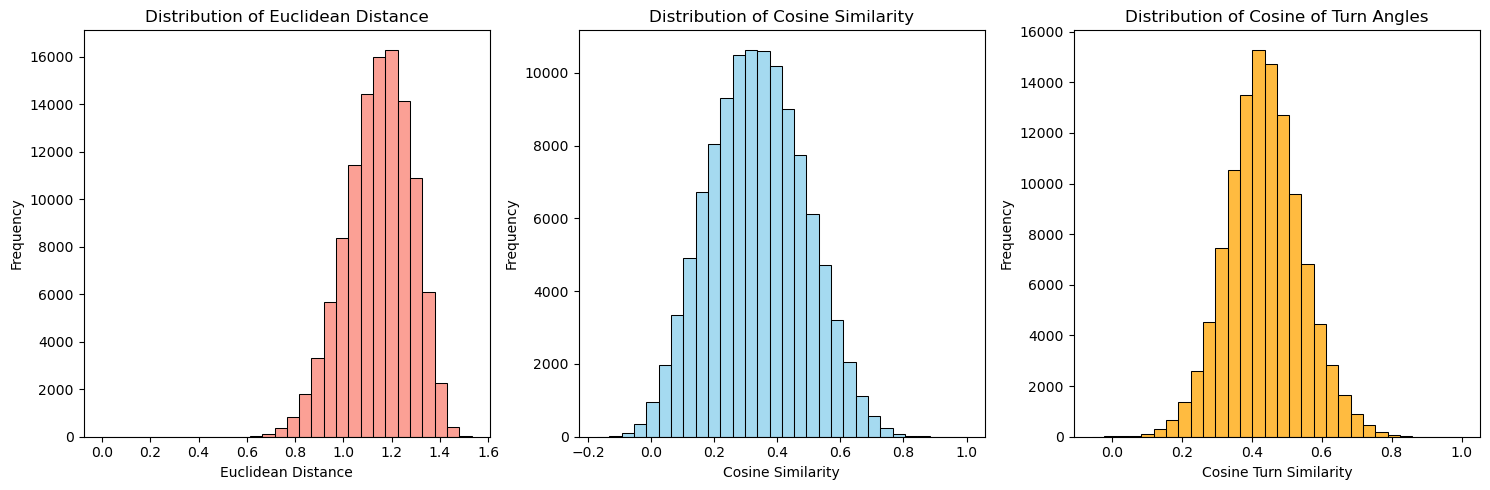

In [36]:
# plot distributions of cosine similarity and euclidean distances and cosine of turn angles
# create figure / axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

# plot A - step length (euclidean distance)
sns.histplot(df['euclidean_distance'], bins=30, kde=False, ax=axes[0], color='salmon')
axes[0].set_title('Distribution of Euclidean Distance')
axes[0].set_xlabel('Euclidean Distance')
axes[0].set_ylabel('Frequency')

# plot B - cosine similarity
sns.histplot(df['cosine_similarity'], bins=30, kde=False, ax=axes[1], color='skyblue')
axes[1].set_title('Distribution of Cosine Similarity')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')

# plot C - turn angles
sns.histplot(df_turn_angle['cosine_turn'], bins=30, kde=False, ax=axes[2], color="orange")
axes[2].set_title('Distribution of Cosine of Turn Angles')
axes[2].set_xlabel('Cosine Turn Similarity')
axes[2].set_ylabel('Frequency')

# plot
plt.tight_layout()
plt.show()

### example heatmap and transcript plots

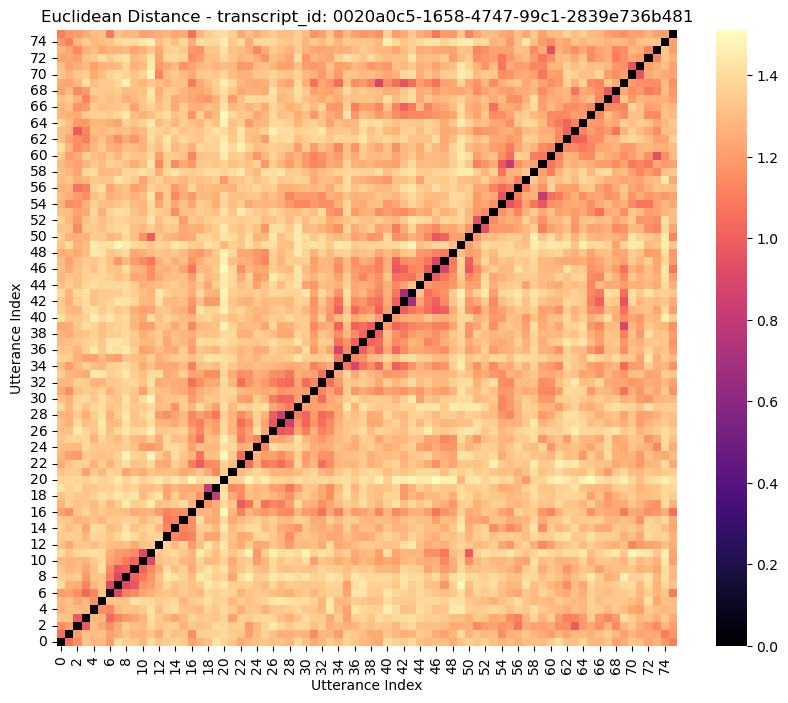

In [18]:
## plot euclidean distance for example transcript
#transcript_id = '0c6b3a4a-7832-44ea-8830-ff727f2b803c'
transcript_id = '0020a0c5-1658-4747-99c1-2839e736b481'
subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)

embedding_matrix = np.vstack(subset['A_embeddings'].values)

distance_matrix = cdist(embedding_matrix, embedding_matrix, metric='euclidean')

plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=False, cmap='magma')
plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
plt.gca().invert_yaxis()
plt.xlabel('Utterance Index')
plt.ylabel('Utterance Index')
plt.show()

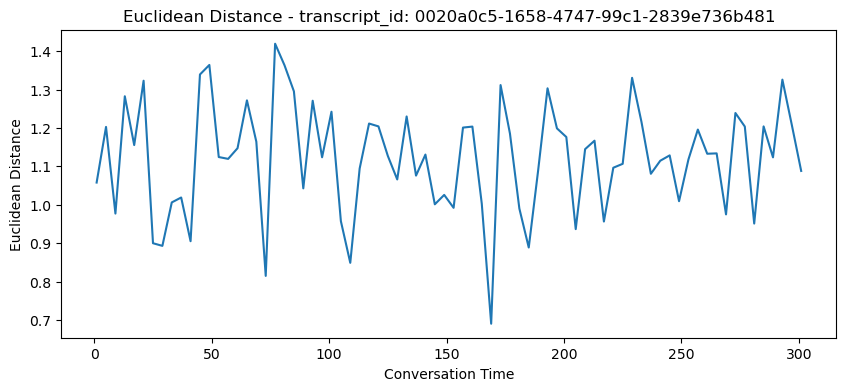

In [19]:
# plot example conversation's peaks of euclidean distances
subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)

plt.figure(figsize=(10, 4))
sns.lineplot(data=subset, x='A_start_turn', y='euclidean_distance')
plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
plt.xlabel('Conversation Time')
plt.ylabel('Euclidean Distance')
plt.show()

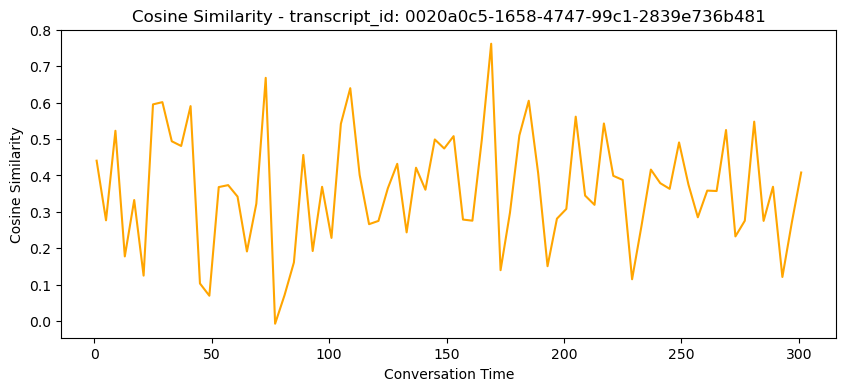

In [20]:
# plot example conversation's peaks of cosine similarities
subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)

plt.figure(figsize=(10, 4))
sns.lineplot(data=subset, x='A_start_turn', y='cosine_similarity', color = 'orange')
plt.title(f'Cosine Similarity - transcript_id: {transcript_id}')
plt.xlabel('Conversation Time')
plt.ylabel('Cosine Similarity')
plt.show()

## Foote Novelty

`A_start_turn` if data is turn-based, `A_start_time` if data is time-based

In [83]:
## FOOTE NOVELTY
all_results = []
type = 'A_start_turn'

for transcript_id, group in df.groupby('transcript_id'):
    # sort by conversation order within each transcript
    group = group.sort_values(type).reset_index(drop=True)
    
    # construct full embedding trajectory (starting with first A_embeddings and ending with last B_embeddings)
    embeddings_list = [emb.squeeze() for emb in group['A_embeddings'].values]
    embeddings_list.append(group['B_embeddings'].values[-1].squeeze())
    embeddings = np.vstack(embeddings_list)
    n = embeddings.shape[0]
    if n < 4:
        continue

    # build time list (one per A, then repeat the last A time for the final B)
    time_list = list(group[type].values)
    time_list.append(time_list[-1])   # align with B_embeddings row

    # compute the self-similarity matrix (how similar is each embedding to all other embeddings in the convo?)
    # https://ccrma.stanford.edu/workshops/mir2009/references/Foote_00.pdf 
    S = cosine_similarity(embeddings)

    # build the checkerboard kernel
    # thanks GPT for help actually making the checkerboard kernel
    kernel_size = 10  # bigger values = detect larger shifts
    k = kernel_size // 2
    kernel = np.block([
        [np.ones((k, k)), -np.ones((k, k))],
        [-np.ones((k, k)), np.ones((k, k))]
    ])
    kernel = kernel / np.sqrt((kernel_size ** 2) / 2)

    # compute foote novelty
    novelty = np.zeros(n)
    for i in range(k, n - k):
        sub = S[i - k:i + k, i - k:i + k]
        novelty[i] = np.sum(sub * kernel)

    # normalize the novelty scores to 0-1
    novelty = (novelty - novelty.min()) / (novelty.max() - novelty.min() + 1e-8)

    # save results
    temp = pd.DataFrame({
        'transcript_id': transcript_id,
        'time_index': np.arange(n),   # each embedding position
        'A_start_turn': time_list,    # save raw info
        'foote_novelty': novelty
    })
    all_results.append(temp)

# combine all transcripts
foote_df = pd.concat(all_results, ignore_index=True)

# mark predicted shifts when foote novelty is 1.5 SD away from overall transcript mean foote novelty
foote_df['predicted_shift'] = 0

for tid, group in foote_df.groupby('transcript_id'):
    mean_nov = group['foote_novelty'].mean()
    std_nov  = group['foote_novelty'].std()
    threshold = mean_nov + 0.5 * std_nov #1.5x, 0.75x
    
    # mark points above threshold
    idx = group.index[group['foote_novelty'] > threshold]
    foote_df.loc[idx, 'predicted_shift'] = 1

    # save threshold
    foote_df.loc[group.index, 'threshold'] = threshold

# preview
foote_df.head()

transcript_id  time_index  A_start_turn  \
0  0020a0c5-1658-4747-99c1-2839e736b481           0             1   
1  0020a0c5-1658-4747-99c1-2839e736b481           1             5   
2  0020a0c5-1658-4747-99c1-2839e736b481           2             9   
3  0020a0c5-1658-4747-99c1-2839e736b481           3            13   
4  0020a0c5-1658-4747-99c1-2839e736b481           4            17   

   foote_novelty  predicted_shift  threshold  
0            0.0                0   0.639716  
1            0.0                0   0.639716  
2            0.0                0   0.639716  
3            0.0                0   0.639716  
4            0.0                0   0.639716

0.6397162401377241


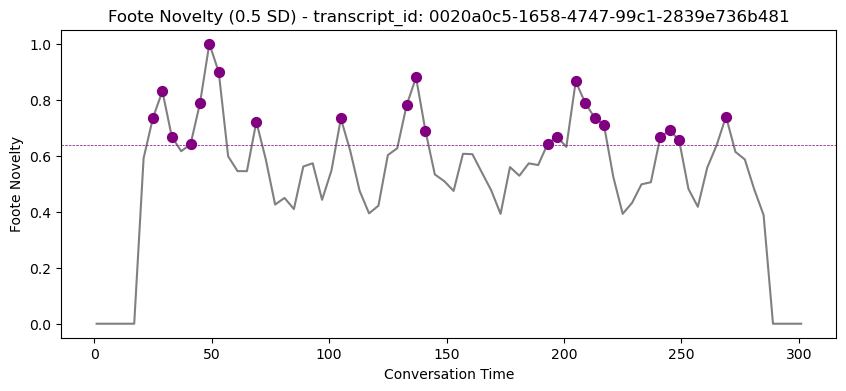

                           transcript_id  time_index  A_start_turn  \
6   0020a0c5-1658-4747-99c1-2839e736b481           6            25   
7   0020a0c5-1658-4747-99c1-2839e736b481           7            29   
8   0020a0c5-1658-4747-99c1-2839e736b481           8            33   
10  0020a0c5-1658-4747-99c1-2839e736b481          10            41   
11  0020a0c5-1658-4747-99c1-2839e736b481          11            45   
12  0020a0c5-1658-4747-99c1-2839e736b481          12            49   
13  0020a0c5-1658-4747-99c1-2839e736b481          13            53   
17  0020a0c5-1658-4747-99c1-2839e736b481          17            69   
26  0020a0c5-1658-4747-99c1-2839e736b481          26           105   
33  0020a0c5-1658-4747-99c1-2839e736b481          33           133   
34  0020a0c5-1658-4747-99c1-2839e736b481          34           137   
35  0020a0c5-1658-4747-99c1-2839e736b481          35           141   
48  0020a0c5-1658-4747-99c1-2839e736b481          48           193   
49  0020a0c5-1658-47

In [87]:
# plot example conversation's peaks of cosine similarities
transcript_id = '0020a0c5-1658-4747-99c1-2839e736b481'
subset = foote_df[foote_df['transcript_id'] == transcript_id].reset_index(drop=True)
predicted_shift_points = subset[subset['predicted_shift'] == 1]

threshold_val = subset['threshold'].iloc[0]   # get threshold value for this transcript
print(threshold_val) # print threshold

plt.figure(figsize=(10, 4))
sns.lineplot(data=subset, x='A_start_turn', y='foote_novelty', color = 'grey')
plt.scatter(predicted_shift_points['A_start_turn'], predicted_shift_points['foote_novelty'], color = 'purple', s = 50, zorder = 3)
plt.axhline(y=threshold_val, linestyle='--', linewidth=0.5, color='purple')
plt.title(f'Foote Novelty (0.5 SD) - transcript_id: {transcript_id}')
plt.xlabel('Conversation Time')
plt.ylabel('Foote Novelty')
plt.show()

## print predicted shifts
print(subset[subset['predicted_shift'] == 1])

## Metrics pre- and post-predicted shift

In [70]:
# merge foote_df (turn_index, foote_novelty) with df (euclidean_distance)
combined_df = foote_df.merge(
    df[['transcript_id', 'A_start_turn', 'euclidean_distance', 'A_utterances']],
    on=['transcript_id', 'A_start_turn'],
    how='left'
)

# merge with the turn angles
combined_df = combined_df.merge(
    df_turn_angle[['transcript_id', 'A_start_turn', 'cosine_turn']],
    on=['transcript_id', 'A_start_turn'],
    how='left'
)

# preview
combined_df.head()

transcript_id  time_index  A_start_turn  \
0  0020a0c5-1658-4747-99c1-2839e736b481           0             1   
1  0020a0c5-1658-4747-99c1-2839e736b481           1             5   
2  0020a0c5-1658-4747-99c1-2839e736b481           2             9   
3  0020a0c5-1658-4747-99c1-2839e736b481           3            13   
4  0020a0c5-1658-4747-99c1-2839e736b481           4            17   

   foote_novelty  predicted_shift  euclidean_distance  \
0            0.0                0            1.057715   
1            0.0                0            1.202609   
2            0.0                0            0.976940   
3            0.0                0            1.282426   
4            0.0                0            1.155388   

                                        A_utterances  cosine_turn  
0  hey I'm gone. good, how are you? Yeah. Yeah, s...     0.483136  
1  too bad. Is this your first time doing? this i...     0.285165  
2  not too bad. Feel a little crappy today but hu...     0.356147  
3  the kid hasn't been feeling good and I think s...     0.442315  
4  22 girls if I'm that's awesome. So I have no k...     0.593736

### plot mean euclidean distance and cosine of turn angle before and after predicted shifts across all conversations

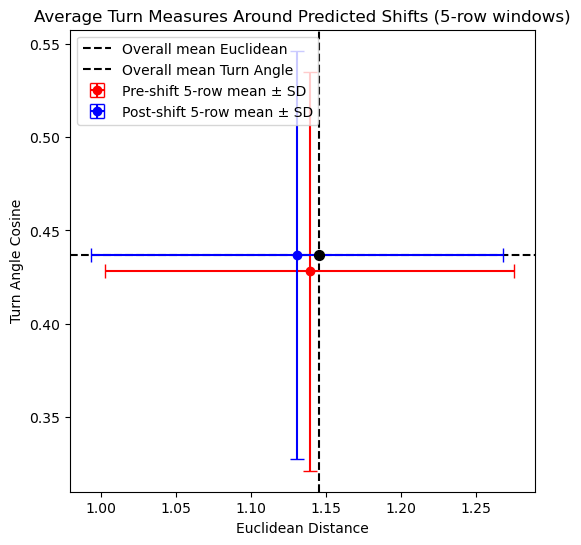

In [72]:
# define window size
window_size = 5  # number of rows before/after predicted shift to average
# define type
type = 'A_start_turn' # A_start_turn or A_start_time

pre_shift_rows = []
post_shift_rows = []

# loop through data transcript-by-transcript
for tid, group in combined_df.groupby('transcript_id'):
    group = group.sort_values('time_index').reset_index(drop=True)
    predicted_idx = np.where(group['predicted_shift'] == 1)[0]
    
    # only select rows from this transcript
    df_transcript = combined_df[combined_df['transcript_id'] == tid]

    for idx in predicted_idx:

        # pre-shift
        start_pre = max(0, idx - window_size)
        pre_window = group.iloc[start_pre:idx]

        for _, row in pre_window.iterrows():
            # match on transcript_id + A_start_time
            match = df_transcript[
                df_transcript[type] == row[type]
            ]

            if not match.empty:
                pre_shift_rows.append({
                    'euclidean_distance': match['euclidean_distance'].values[0],
                    'cosine_turn': match['cosine_turn'].values[0]
                })

        # post-shift
        end_post = min(len(group), idx + 1 + window_size)
        post_window = group.iloc[idx+1:end_post]

        for _, row in post_window.iterrows():
            match = df_transcript[
                df_transcript[type] == row[type]
            ]

            if not match.empty:
                post_shift_rows.append({
                    'euclidean_distance': match['euclidean_distance'].values[0],
                    'cosine_turn': match['cosine_turn'].values[0]
                })

# convert to DataFrames
pre_shift_df = pd.DataFrame(pre_shift_rows).dropna()
post_shift_df = pd.DataFrame(post_shift_rows).dropna()

# summary stats
pre_mean_euc, pre_sd_euc = pre_shift_df['euclidean_distance'].mean(), pre_shift_df['euclidean_distance'].std()
pre_mean_cos, pre_sd_cos = pre_shift_df['cosine_turn'].mean(), pre_shift_df['cosine_turn'].std()

post_mean_euc, post_sd_euc = post_shift_df['euclidean_distance'].mean(), post_shift_df['euclidean_distance'].std()
post_mean_cos, post_sd_cos = post_shift_df['cosine_turn'].mean(), post_shift_df['cosine_turn'].std()

overall_mean_euc = combined_df['euclidean_distance'].mean()
overall_mean_cos = combined_df['cosine_turn'].mean()

# plot
fig, ax = plt.subplots(figsize=(6,6))
# mean lines
ax.axvline(overall_mean_euc, color='black', linestyle='--', label='Overall mean Euclidean')
ax.axhline(overall_mean_cos, color='black', linestyle='--', label='Overall mean Turn Angle')
# intersection point of overall means
ax.scatter(overall_mean_euc, overall_mean_cos, color='black', s=50, zorder=5)
# pre-shift mean ± SD
ax.errorbar(
    pre_mean_euc, pre_mean_cos,
    xerr=pre_sd_euc, yerr=pre_sd_cos,
    fmt='o', color='red', ecolor='red', capsize=5,
    label=f'Pre-shift {window_size}-row mean ± SD'
)
# post-shift mean ± SD
ax.errorbar(
    post_mean_euc, post_mean_cos,
    xerr=post_sd_euc, yerr=post_sd_cos,
    fmt='o', color='blue', ecolor='blue', capsize=5,
    label=f'Post-shift {window_size}-row mean ± SD'
)
ax.set_xlabel('Euclidean Distance')
ax.set_ylabel('Turn Angle Cosine')
ax.set_title(f'Average Turn Measures Around Predicted Shifts ({window_size}-row windows)')
ax.legend()
plt.show()

## ALIGNMENT

How well do predicted shifts at this utterance structure align with annotation data?

In [ ]:
# load full sample annotation data
ann_df = pd.read_csv('/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/processed/full-sample/full_sample_processed.csv')
ann_df.head()


turn_id                   speaker  \
0       13  5c270d8f2c45d400014909e8   
1       36  5c270d8f2c45d400014909e8   
2       51  5c270d8f2c45d400014909e8   
3       63  5c270d8f2c45d400014909e8   
4       78  5eece89d63352e0c327ddb0b   

                                    currentUtterance       previous_topic  \
0  just got done trying to figure out what to do ...           Test Topic   
1                       Yeah. What part of new york?   What is for dinner   
2  how is it right now, as far as like environmen...  Living arrangements   
3  Well, we were doing pretty good and lately the...             Politics   
4  it was mostly really, it was seriously overblo...   Different politics   

             new_topic                                        PID  \
0   What is for dinner  [False, '6100b9bc3ca21392600e905c', None]   
1  Living arrangements  [False, '6100b9bc3ca21392600e905c', None]   
2             Politics  [False, '6100b9bc3ca21392600e905c', None]   
3   Different politics  [False, '6100b9bc3ca21392600e905c', None]   
4         New politics  [False, '6100b9bc3ca21392600e905c', None]   

           time                         transcript_id  count  
0  1.745012e+12  339012e4-ada1-4c88-839d-08a6842b5903  205.0  
1  1.745012e+12  339012e4-ada1-4c88-839d-08a6842b5903  205.0  
2  1.745012e+12  339012e4-ada1-4c88-839d-08a6842b5903  205.0  
3  1.745012e+12  339012e4-ada1-4c88-839d-08a6842b5903  205.0  
4  1.745012e+12  339012e4-ada1-4c88-839d-08a6842b5903  205.0

In [73]:
# normalize utterance text between combined_df and ann_df
def normalize_text(s):
    return " ".join(str(s).lower().strip().split())

combined_df["utter_norm"] = combined_df["A_utterances"].apply(normalize_text)
ann_df["utter_norm"] = ann_df["currentUtterance"].apply(normalize_text)

In [74]:
# count how many PIDs marked a given utterance as a shift within each transcript
pid_counts = (ann_df.groupby(['transcript_id', 'utter_norm'])
              .PID.nunique()
              .reset_index(name='participant_shifts'))
# preview
pid_counts.head()

transcript_id  \
0  0020a0c5-1658-4747-99c1-2839e736b481   
1  0020a0c5-1658-4747-99c1-2839e736b481   
2  0020a0c5-1658-4747-99c1-2839e736b481   
3  0020a0c5-1658-4747-99c1-2839e736b481   
4  0020a0c5-1658-4747-99c1-2839e736b481   

                                          utter_norm  participant_shifts  
0  are there any insider secrets you can tell me ...                   1  
1  do you guys do stuff, did you guys do stuff fo...                   1  
2                          i work at an old factory,                   1  
3  like talking all the things i want to do as so...                   1  
4  my god, i'm let's see myself personally, i don...                   1

In [75]:
# merge pid_shifts with combined_df
combined_ann_df = combined_df.merge(
    pid_counts,
    on=['transcript_id','utter_norm'],
    how='left'
)
# fill NAs with 0
combined_ann_df["participant_shifts"] = combined_ann_df["participant_shifts"].fillna(0)
# make binary
combined_ann_df["participant_shifts"] = (combined_ann_df["participant_shifts"] > 0).astype(int)
# preview
combined_ann_df.head()

transcript_id  time_index  A_start_turn  \
0  0020a0c5-1658-4747-99c1-2839e736b481           0             1   
1  0020a0c5-1658-4747-99c1-2839e736b481           1             5   
2  0020a0c5-1658-4747-99c1-2839e736b481           2             9   
3  0020a0c5-1658-4747-99c1-2839e736b481           3            13   
4  0020a0c5-1658-4747-99c1-2839e736b481           4            17   

   foote_novelty  predicted_shift  euclidean_distance  \
0            0.0                0            1.057715   
1            0.0                0            1.202609   
2            0.0                0            0.976940   
3            0.0                0            1.282426   
4            0.0                0            1.155388   

                                        A_utterances  cosine_turn  \
0  hey I'm gone. good, how are you? Yeah. Yeah, s...     0.483136   
1  too bad. Is this your first time doing? this i...     0.285165   
2  not too bad. Feel a little crappy today but hu...     0.356147   
3  the kid hasn't been feeling good and I think s...     0.442315   
4  22 girls if I'm that's awesome. So I have no k...     0.593736   

                                          utter_norm  participant_shifts  
0  hey i'm gone. good, how are you? yeah. yeah, s...                   0  
1  too bad. is this your first time doing? this i...                   0  
2  not too bad. feel a little crappy today but hu...                   0  
3  the kid hasn't been feeling good and i think s...                   0  
4  22 girls if i'm that's awesome. so i have no k...                   0

In [76]:
y_pid = combined_ann_df["participant_shifts"].astype(int)          # participant ratings
y_pred = combined_ann_df["predicted_shift"].astype(int)            # model predictions

In [77]:
# calculate hit rate for foote predicted > participant
# how well do predicted shifts detect participant-identified shifts?
TP = np.sum((y_pid == 1) & (y_pred == 1))
FN = np.sum((y_pid == 1) & (y_pred == 0))
FP = np.sum((y_pid == 0) & (y_pred == 1))
TN = np.sum((y_pid == 0) & (y_pred == 0))

hit_rate_foote_to_PID = TP / (TP + FN) if (TP + FN) > 0 else np.nan
fa_rate_foote_to_PID  = FP / (FP + TN) if (FP + TN) > 0 else np.nan

# show
hit_rate_foote_to_PID, fa_rate_foote_to_PID

(0.5, 0.3043226959049988)

In [78]:
# calculate hit rate for participant > foote predicted
# how well do participant shifts align with foote-predicted shifts?
TP = np.sum((y_pred == 1) & (y_pid == 1))
FN = np.sum((y_pred == 1) & (y_pid == 0))
FP = np.sum((y_pred == 0) & (y_pid == 1))
TN = np.sum((y_pred == 0) & (y_pid == 0))

hit_rate_PID_to_foote = TP / (TP + FN) if (TP + FN) > 0 else np.nan
fa_rate_PID_to_foote = FP / (FP + TN) if (FP + TN) > 0 else np.nan

# show
hit_rate_PID_to_foote, fa_rate_PID_to_foote

(0.0003452045336862091, 0.00015103838892385147)

## 60 second utterance windows, sliding by 5 seconds

In [3]:
# load 60 second time-based windows
df = pd.read_pickle(output_dir + '/full_sample_tile_60_sec_split_utterances.pkl')
df.head()

transcript_id  mode  window_size  gap_size  \
0  0020a0c5-1658-4747-99c1-2839e736b481  time           60         0   
1  0020a0c5-1658-4747-99c1-2839e736b481  time           60         0   
2  0020a0c5-1658-4747-99c1-2839e736b481  time           60         0   
3  0020a0c5-1658-4747-99c1-2839e736b481  time           60         0   
4  0020a0c5-1658-4747-99c1-2839e736b481  time           60         0   

   A_start_time  A_end_time  B_start_time  B_end_time  A_raw_start  A_raw_end  \
0             0          60            60         120       200.74     269.36   
1             5          65            65         125       202.14     269.36   
2            10          70            70         130       202.14     274.65   
3            15          75            75         135       214.03     276.46   
4            20          80            80         140       217.30     282.12   

   B_raw_start  B_raw_end                                       A_utterances  \
0       251.04     326.95  hey I'm gone. good, how are you? Yeah. Yeah, s...   
1       251.04     326.95  good, how are you? Yeah. Yeah, so this will be...   
2       268.44     333.26  good, how are you? Yeah. Yeah, so this will be...   
3       274.94     338.36  too bad. Is this your first time doing? this i...   
4       277.02     343.76  this is actually my first one so yeah it's my ...   

                                        B_utterances  \
0  thanks, Tiny firm sponge. I swear that's that'...   
1  thanks, Tiny firm sponge. I swear that's that'...   
2  yeah the other one got sent home from school t...   
3  you know how many kids do you have? 22 girls i...   
4  22 girls if I'm that's awesome. So I have no k...   

                                        A_embeddings  \
0  [[-0.02723414, -0.016473606, 0.080718726, 0.01...   
1  [[-0.028731145, -0.014363082, 0.06715969, 0.01...   
2  [[-0.048668917, -0.019317897, 0.06675714, 0.00...   
3  [[-0.030674124, -0.0073758666, 0.05366883, -0....   
4  [[-0.049057648, -0.015586929, 0.060688626, -0....   

                                        B_embeddings  cosine_similarity  \
0  [[-0.060773935, -0.04257788, 0.07446801, 0.077...           0.565091   
1  [[-0.060773935, -0.04257788, 0.07446801, 0.077...           0.576882   
2  [[-0.008008794, -0.04356668, 0.027158318, 0.09...           0.387899   
3  [[0.008727548, -0.07959748, 0.00069137814, 0.1...           0.321199   
4  [[0.032361522, -0.06461531, 0.0028393136, 0.10...           0.337325   

   euclidean_distance  
0            0.932640  
1            0.919911  
2            1.106437  
3            1.165162  
4            1.151238

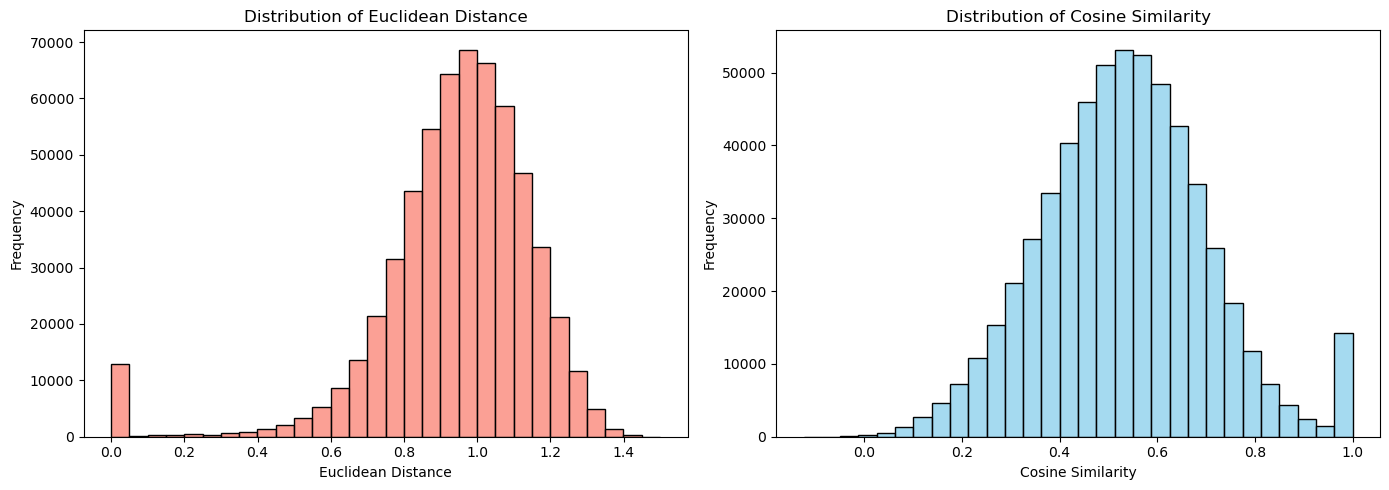

In [4]:
# plot distributions of cosine similarity and euclidean distances
# create figure / axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# plot A - step length (euclidean distance)
sns.histplot(df['euclidean_distance'], bins=30, kde=False, ax=axes[0], color='salmon')
axes[0].set_title('Distribution of Euclidean Distance')
axes[0].set_xlabel('Euclidean Distance')
axes[0].set_ylabel('Frequency')

# plot B - turn angles (cosine similarity)
sns.histplot(df['cosine_similarity'], bins=30, kde=False, ax=axes[1], color='skyblue')
axes[1].set_title('Distribution of Cosine Similarity')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')

# plot
plt.tight_layout()
plt.show()

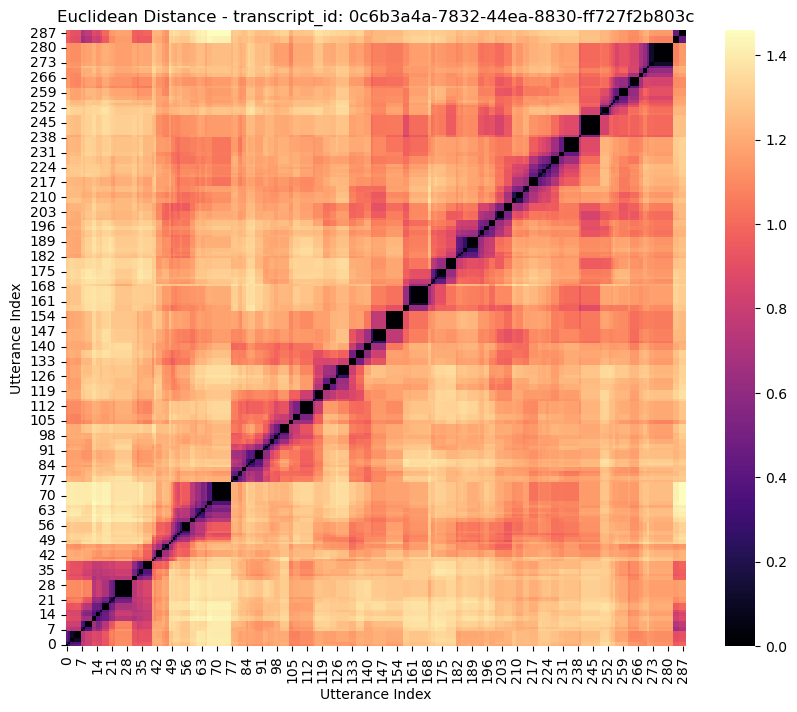

In [5]:
## plot euclidean distance for example transcript
transcript_id = '0c6b3a4a-7832-44ea-8830-ff727f2b803c'
subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)

embedding_matrix = np.vstack(subset['A_embeddings'].values)

distance_matrix = cdist(embedding_matrix, embedding_matrix, metric='euclidean')

plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=False, cmap='magma')
plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
plt.gca().invert_yaxis()
plt.xlabel('Utterance Index')
plt.ylabel('Utterance Index')
plt.show()

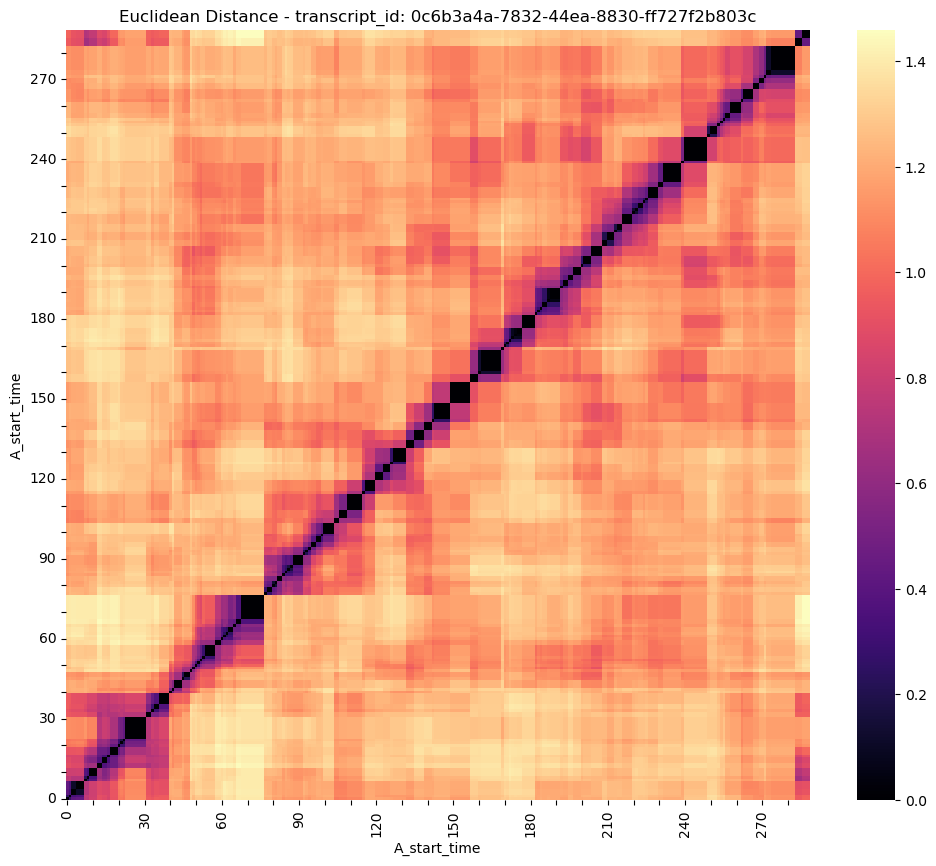

In [32]:
transcript_id = '0c6b3a4a-7832-44ea-8830-ff727f2b803c'
subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)

embedding_matrix = np.vstack(subset['A_embeddings'].values)
distance_matrix = cdist(embedding_matrix, embedding_matrix, metric='euclidean')

raw_times = subset['A_start_time']

plt.figure(figsize=(12, 10))
ax = sns.heatmap(distance_matrix, annot=False, cmap='magma')

# Choose tick interval (e.g., show one every 10)
interval = 10
tick_positions = np.arange(0, len(raw_times), interval)

ax.set_xticks(tick_positions + 0.5)
ax.set_yticks(tick_positions + 0.5)

plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
plt.gca().invert_yaxis()
plt.xlabel('A_start_time')
plt.ylabel('A_start_time')
plt.show()


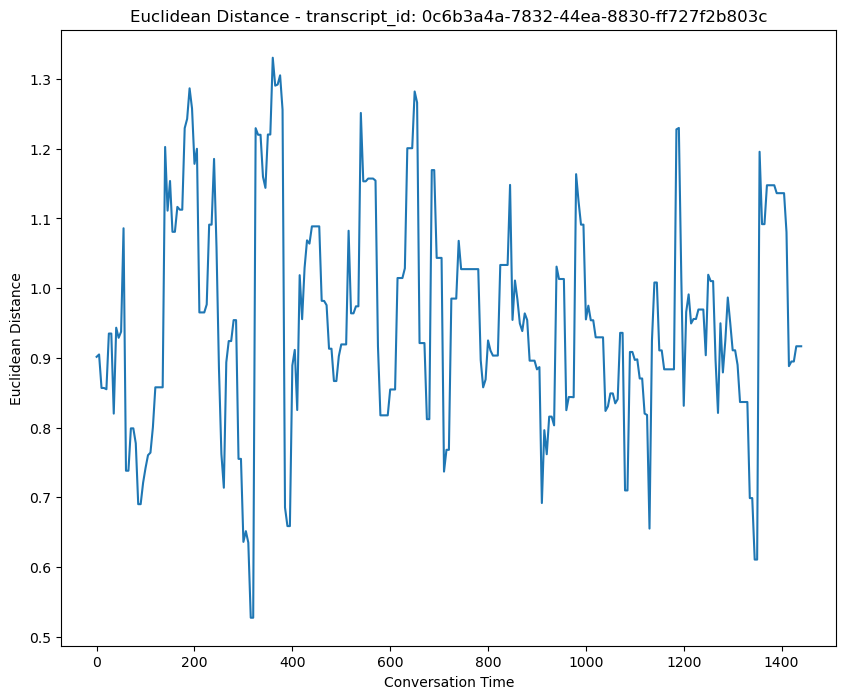

In [8]:
# plot example conversation's peaks of euclidean distances
subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.lineplot(data=subset, x='A_start_time', y='euclidean_distance')
plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
plt.xlabel('Conversation Time')
plt.ylabel('Euclidean Distance')
plt.show()

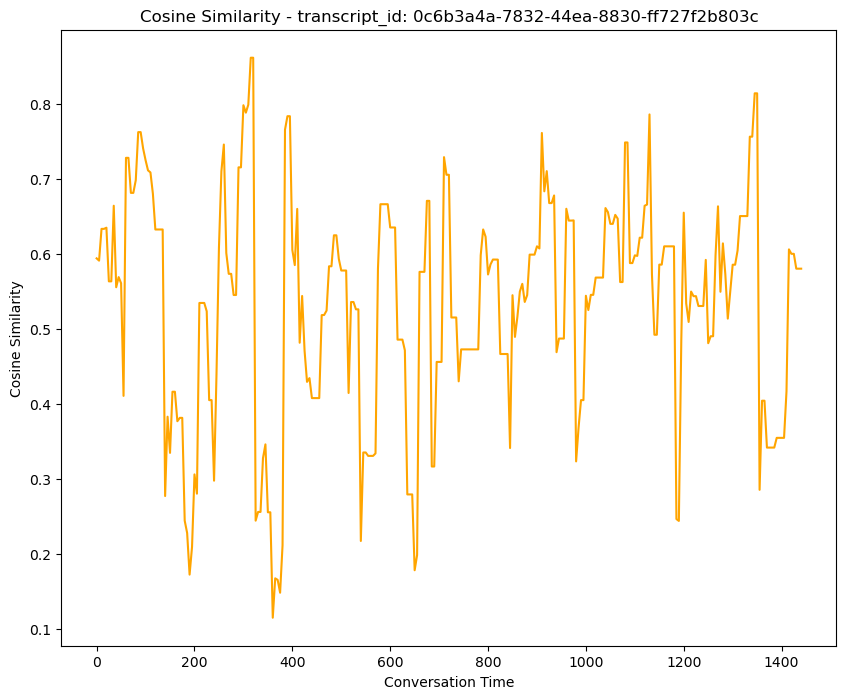

In [11]:
# plot example conversation's peaks of cosine similarities
subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.lineplot(data=subset, x='A_start_time', y='cosine_similarity', color = 'orange')
plt.title(f'Cosine Similarity - transcript_id: {transcript_id}')
plt.xlabel('Conversation Time')
plt.ylabel('Cosine Similarity')
plt.show()

In [23]:
## FOOTE NOVELTY

all_results = []

for transcript_id, group in df.groupby('transcript_id'):
    # sort by conversation order within each transcript
    group = group.sort_values('A_start_time').reset_index(drop=True)
    
    # construct full embedding trajectory (starting with first A_embeddings and ending with last B_embeddings)
    embeddings_list = [emb.squeeze() for emb in group['A_embeddings'].values]
    embeddings_list.append(group['B_embeddings'].values[-1].squeeze())
    embeddings = np.vstack(embeddings_list)
    n = embeddings.shape[0]
    if n < 4:
        continue

    # build time list (one per A, then repeat the last A time for the final B)
    time_list = list(group['A_start_time'].values)
    time_list.append(time_list[-1])   # align with B_embeddings row

    # compute the self-similarity matrix (how similar is each embedding to all other embeddings in the convo?)
    # https://ccrma.stanford.edu/workshops/mir2009/references/Foote_00.pdf 
    S = cosine_similarity(embeddings)

    # build the checkerboard kernel
    # thanks GPT for help actually making the checkerboard kernel
    kernel_size = 10  # bigger values = detect larger shifts
    k = kernel_size // 2
    kernel = np.block([
        [np.ones((k, k)), -np.ones((k, k))],
        [-np.ones((k, k)), np.ones((k, k))]
    ])
    kernel = kernel / np.sqrt((kernel_size ** 2) / 2)

    # compute foote novelty
    novelty = np.zeros(n)
    for i in range(k, n - k):
        sub = S[i - k:i + k, i - k:i + k]
        novelty[i] = np.sum(sub * kernel)

    # normalize the novelty scores to 0-1
    novelty = (novelty - novelty.min()) / (novelty.max() - novelty.min() + 1e-8)

    # save results
    temp = pd.DataFrame({
        'transcript_id': transcript_id,
        'time_index': np.arange(n),   # each embedding position
        'A_start_time': time_list,    # save raw time too
        'foote_novelty': novelty
    })
    all_results.append(temp)

# Combine all transcripts
foote_df_60 = pd.concat(all_results, ignore_index=True)

In [24]:
# mark predicted shifts when foote novelty is 1.5 SD away from overall transcript mean foote novelty
# HELEN FUTURE: make a more local threshold too
foote_df_60['predicted_shift'] = 0

for tid, group in foote_df_60.groupby('transcript_id'):
    mean_nov = group['foote_novelty'].mean()
    std_nov  = group['foote_novelty'].std()
    threshold = mean_nov + 1.5 * std_nov
    
    # mark points above threshold
    idx = group.index[group['foote_novelty'] > threshold]
    foote_df_60.loc[idx, 'predicted_shift'] = 1

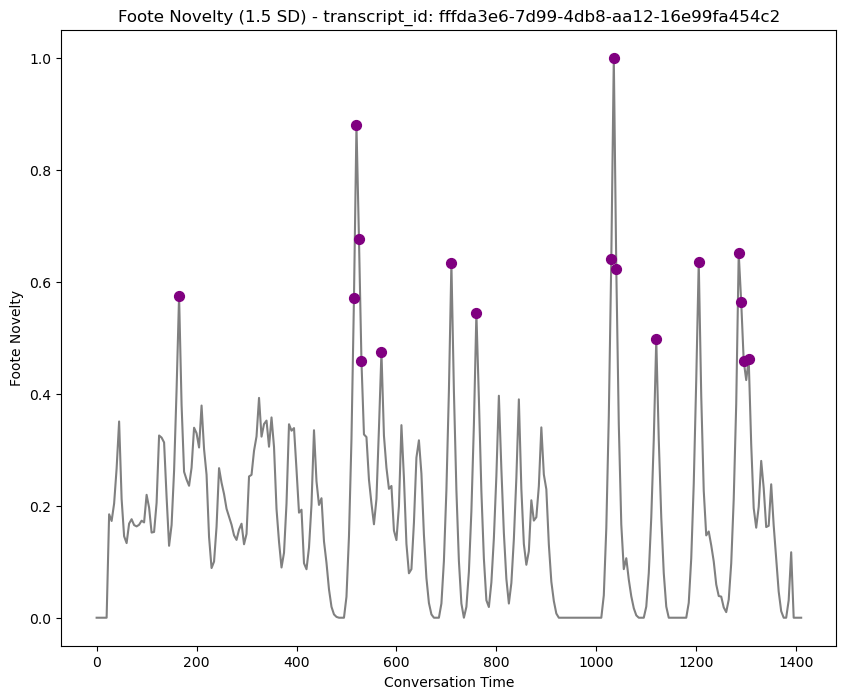

In [25]:
# plot example conversation's peaks of cosine similarities
subset = foote_df_60[foote_df_60['transcript_id'] == transcript_id].reset_index(drop=True)
predicted_shift_points = subset[subset['predicted_shift'] == 1]

plt.figure(figsize=(10, 8))
sns.lineplot(data=subset, x='A_start_time', y='foote_novelty', color = 'grey')
plt.scatter(predicted_shift_points['A_start_time'], predicted_shift_points['foote_novelty'], color = 'purple', s = 50, zorder = 3)
plt.title(f'Foote Novelty (1.5 SD) - transcript_id: {transcript_id}')
plt.xlabel('Conversation Time')
plt.ylabel('Foote Novelty')
plt.show()


In [26]:
## print predicted shifts
print(subset[subset['predicted_shift'] == 1])


                            transcript_id  time_index  A_start_time  \
33   fffda3e6-7d99-4db8-aa12-16e99fa454c2          33           165   
103  fffda3e6-7d99-4db8-aa12-16e99fa454c2         103           515   
104  fffda3e6-7d99-4db8-aa12-16e99fa454c2         104           520   
105  fffda3e6-7d99-4db8-aa12-16e99fa454c2         105           525   
106  fffda3e6-7d99-4db8-aa12-16e99fa454c2         106           530   
114  fffda3e6-7d99-4db8-aa12-16e99fa454c2         114           570   
142  fffda3e6-7d99-4db8-aa12-16e99fa454c2         142           710   
152  fffda3e6-7d99-4db8-aa12-16e99fa454c2         152           760   
206  fffda3e6-7d99-4db8-aa12-16e99fa454c2         206          1030   
207  fffda3e6-7d99-4db8-aa12-16e99fa454c2         207          1035   
208  fffda3e6-7d99-4db8-aa12-16e99fa454c2         208          1040   
224  fffda3e6-7d99-4db8-aa12-16e99fa454c2         224          1120   
241  fffda3e6-7d99-4db8-aa12-16e99fa454c2         241          1205   
257  f

In [48]:
## overlay participant ratings on the foote novelty to see how well they align
pid_ratings = pd.read_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/processed/full-sample/full_sample_processed.csv")
# filter to example participant
example_transcript_ratings = pid_ratings[pid_ratings['transcript_id'] == transcript_id]
# preview
example_transcript_ratings.head()

turn_id                   speaker  \
23595        4  55a43cf3fdf99b02ff6cb0b4   
23596        5  5f220462c16ecb68c97ccad9   
23597       15  5f220462c16ecb68c97ccad9   
23598       21  5f220462c16ecb68c97ccad9   
23599       25  5f220462c16ecb68c97ccad9   

                                        currentUtterance    previous_topic  \
23595  It might also meet my dog because anytime I st...      introduction   
23596  Yeah how are you? Part of also participant in ...           glasses   
23597  Yeah. Hey I mean in the long run it pays big. ...  prolific surveys   
23598  work in the health care. I work in a nursing a...         saving up   
23599                       Nice. Yet you have Children.         workplace   

              new_topic                                        PID  \
23595           glasses  [False, '5d9fae684bf6c600144e673b', None]   
23596  prolific surveys  [False, '5d9fae684bf6c600144e673b', None]   
23597         saving up  [False, '5d9fae684bf6c600144e673b', None]   
23598         workplace  [False, '5d9fae684bf6c600144e673b', None]   
23599          children  [False, '5d9fae684bf6c600144e673b', None]   

               time                         transcript_id  count  
23595  1.745271e+12  0c6b3a4a-7832-44ea-8830-ff727f2b803c  379.0  
23596  1.745271e+12  0c6b3a4a-7832-44ea-8830-ff727f2b803c  379.0  
23597  1.745271e+12  0c6b3a4a-7832-44ea-8830-ff727f2b803c  379.0  
23598  1.745271e+12  0c6b3a4a-7832-44ea-8830-ff727f2b803c  379.0  
23599  1.745271e+12  0c6b3a4a-7832-44ea-8830-ff727f2b803c  379.0

In [51]:
# get the average number of utterance selections
df_task_counts = (
    example_transcript_ratings.groupby(['transcript_id', 'currentUtterance'])
           .agg(num_participants=('PID', 'nunique'))
           .reset_index())
# save copy of subset of one transcript
df_test = subset

# preview
df_task_counts.head()

transcript_id  \
0  0c6b3a4a-7832-44ea-8830-ff727f2b803c   
1  0c6b3a4a-7832-44ea-8830-ff727f2b803c   
2  0c6b3a4a-7832-44ea-8830-ff727f2b803c   
3  0c6b3a4a-7832-44ea-8830-ff727f2b803c   
4  0c6b3a4a-7832-44ea-8830-ff727f2b803c   

                                    currentUtterance  num_participants  
0                          And but you see any UFOs.                 1  
1  I do yeah for sure and I they have they do tra...                 1  
2  It might also meet my dog because anytime I st...                 1  
3  It was it was interesting, I liked it. I it wa...                 1  
4                       Nice. Yet you have Children.                 1

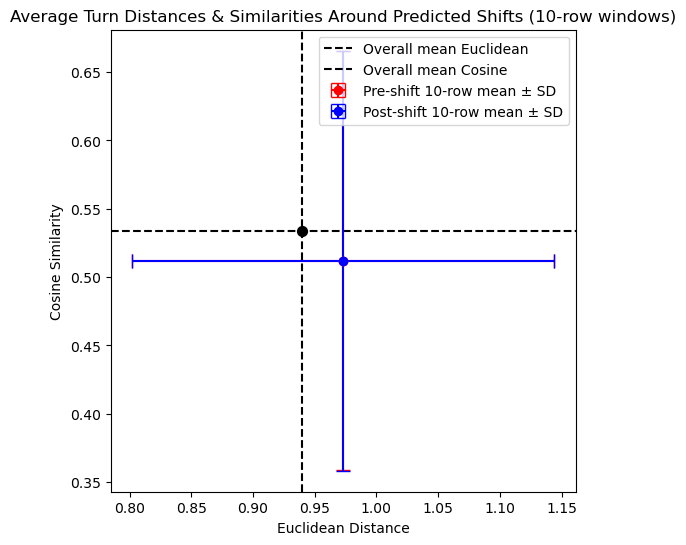

In [35]:
# now get the average turn angle and step length overall and for utterances before and after predicted shifts

window_size = 10  # number of rows before/after predicted shift to average

pre_shift_rows = []
post_shift_rows = []

for tid, group in foote_df_60.groupby('transcript_id'):
    group = group.sort_values('time_index').reset_index(drop=True)
    predicted_idx = np.where(group['predicted_shift'] == 1)[0]
    
    df_transcript = df[df['transcript_id'] == tid]
    
    for idx in predicted_idx:
        # --- Pre-shift window ---
        start_pre = max(0, idx - window_size)
        pre_window = group.iloc[start_pre:idx]
        
        for _, row in pre_window.iterrows():
            match = df_transcript[(df_transcript['A_start_time'] <= row['time_index']) &
                                  (df_transcript['B_end_time'] >= row['time_index'])]
            if not match.empty:
                pre_shift_rows.append({
                    'euclidean_distance': match['euclidean_distance'].values[0],
                    'cosine_similarity': match['cosine_similarity'].values[0]
                })
        
        # --- Post-shift window ---
        end_post = min(len(group), idx + 1 + window_size)
        post_window = group.iloc[idx+1:end_post]
        
        for _, row in post_window.iterrows():
            match = df_transcript[(df_transcript['A_start_time'] <= row['time_index']) &
                                  (df_transcript['B_end_time'] >= row['time_index'])]
            if not match.empty:
                post_shift_rows.append({
                    'euclidean_distance': match['euclidean_distance'].values[0],
                    'cosine_similarity': match['cosine_similarity'].values[0]
                })

# Combine into DataFrames
pre_shift_df = pd.DataFrame(pre_shift_rows).dropna()
post_shift_df = pd.DataFrame(post_shift_rows).dropna()

# Compute mean and SD
pre_mean_euc, pre_sd_euc = pre_shift_df['euclidean_distance'].mean(), pre_shift_df['euclidean_distance'].std()
pre_mean_cos, pre_sd_cos = pre_shift_df['cosine_similarity'].mean(), pre_shift_df['cosine_similarity'].std()

post_mean_euc, post_sd_euc = post_shift_df['euclidean_distance'].mean(), post_shift_df['euclidean_distance'].std()
post_mean_cos, post_sd_cos = post_shift_df['cosine_similarity'].mean(), post_shift_df['cosine_similarity'].std()

# --- Plot ---
fig, ax = plt.subplots(figsize=(6,6))

# Overall mean lines
ax.axvline(df['euclidean_distance'].mean(), color='black', linestyle='--', label='Overall mean Euclidean')
ax.axhline(df['cosine_similarity'].mean(), color='black', linestyle='--', label='Overall mean Cosine')

# Intersection point
ax.scatter(df['euclidean_distance'].mean(), df['cosine_similarity'].mean(), color='black', s=50, zorder=5)

# Pre-shift window mean ± SD
ax.errorbar(pre_mean_euc, pre_mean_cos,
            xerr=pre_sd_euc, yerr=pre_sd_cos,
            fmt='o', color='red', ecolor='red', capsize=5,
            label=f'Pre-shift {window_size}-row mean ± SD')

# Post-shift window mean ± SD
ax.errorbar(post_mean_euc, post_mean_cos,
            xerr=post_sd_euc, yerr=post_sd_cos,
            fmt='o', color='blue', ecolor='blue', capsize=5,
            label=f'Post-shift {window_size}-row mean ± SD')

ax.set_xlabel('Euclidean Distance')
ax.set_ylabel('Cosine Similarity')
ax.set_title(f'Average Turn Distances & Similarities Around Predicted Shifts ({window_size}-row windows)')
ax.legend()
plt.show()

## Turn Angle

In [38]:
## apply turn angle to data frame
df_turn_angle = compute_turn_angles_adjacent_windows(df)
df_turn_angle.head()

transcript_id  turn_index  A_start_time  cosine_turn
0  0020a0c5-1658-4747-99c1-2839e736b481           0             0     0.000000
1  0020a0c5-1658-4747-99c1-2839e736b481           1             5    -0.120349
2  0020a0c5-1658-4747-99c1-2839e736b481           2            10     0.024007
3  0020a0c5-1658-4747-99c1-2839e736b481           3            15     0.085321
4  0020a0c5-1658-4747-99c1-2839e736b481           4            20     0.449533

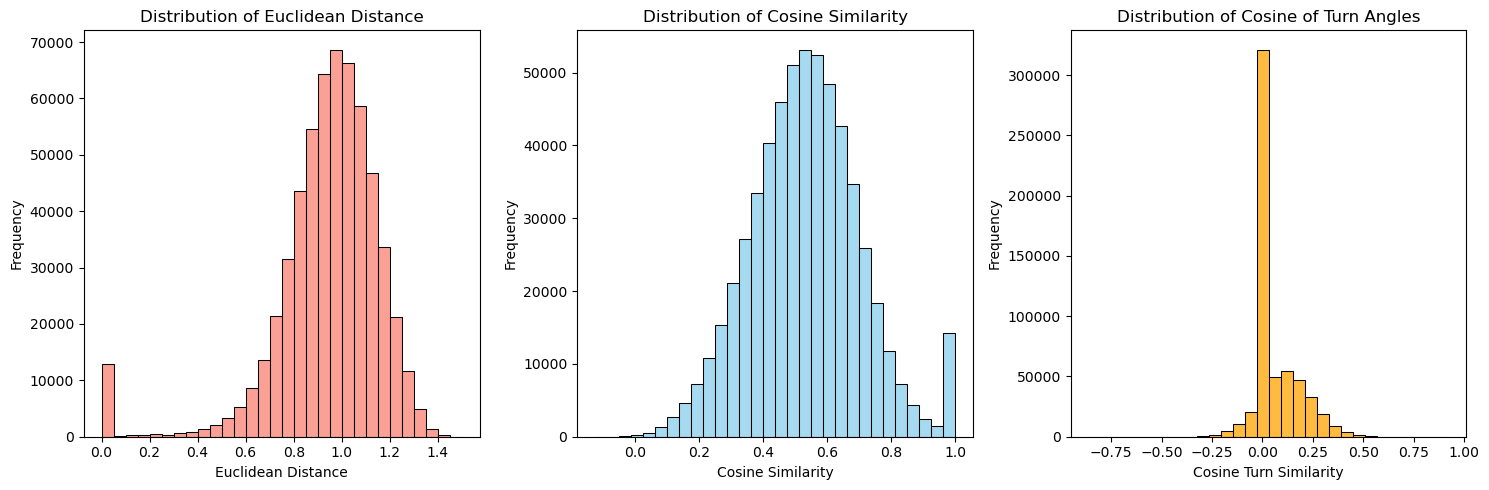

In [39]:
# plot distributions of cosine similarity and euclidean distances and cosine of turn angles
# create figure / axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

# plot A - step length (euclidean distance)
sns.histplot(df['euclidean_distance'], bins=30, kde=False, ax=axes[0], color='salmon')
axes[0].set_title('Distribution of Euclidean Distance')
axes[0].set_xlabel('Euclidean Distance')
axes[0].set_ylabel('Frequency')

# plot B - cosine similarity
sns.histplot(df['cosine_similarity'], bins=30, kde=False, ax=axes[1], color='skyblue')
axes[1].set_title('Distribution of Cosine Similarity')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')

# plot C - turn angles
sns.histplot(df_turn_angle['cosine_turn'], bins=30, kde=False, ax=axes[2], color="orange")
axes[2].set_title('Distribution of Cosine of Turn Angles')
axes[2].set_xlabel('Cosine Turn Similarity')
axes[2].set_ylabel('Frequency')

# plot
plt.tight_layout()
plt.show()

In [ ]:
# merge foote_df_60 (turn_index, foote_novelty) with df (euclidean_distance)
combined_df = foote_df_60.merge(
    df[['transcript_id', 'A_start_time', 'euclidean_distance']],
    on=['transcript_id', 'A_start_time'],
    how='left'
)

# merge with the turn angles
combined_df = combined_df.merge(
    df_turn_angle[['transcript_id', 'A_start_time', 'cosine_turn']],
    on=['transcript_id', 'A_start_time'],
    how='left'
)

# preview
combined_df.head()

transcript_id  time_index  A_start_time  \
0  0020a0c5-1658-4747-99c1-2839e736b481           0             0   
1  0020a0c5-1658-4747-99c1-2839e736b481           1             5   
2  0020a0c5-1658-4747-99c1-2839e736b481           2            10   
3  0020a0c5-1658-4747-99c1-2839e736b481           3            15   
4  0020a0c5-1658-4747-99c1-2839e736b481           4            20   

   foote_novelty  predicted_shift  euclidean_distance  cosine_turn  
0            0.0                0            0.932640     0.000000  
1            0.0                0            0.919911    -0.120349  
2            0.0                0            1.106437     0.024007  
3            0.0                0            1.165162     0.085321  
4            0.0                0            1.151238     0.449533

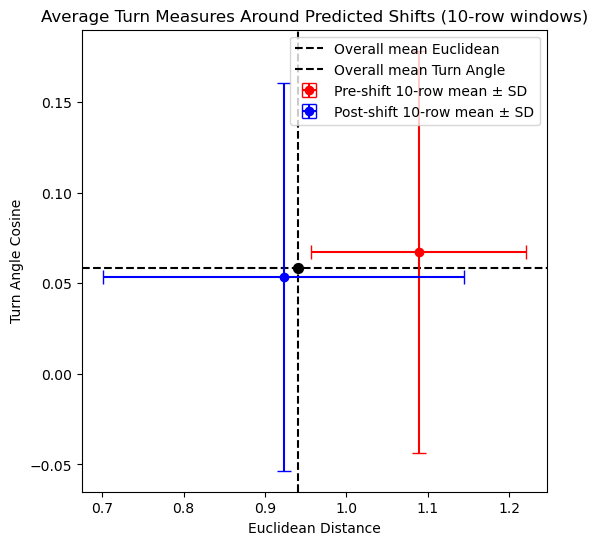

In [46]:
# --- Parameters ---
window_size = 10  # number of rows before/after predicted shift to average

pre_shift_rows = []
post_shift_rows = []

# Loop transcript-by-transcript
for tid, group in combined_df.groupby('transcript_id'):
    group = group.sort_values('time_index').reset_index(drop=True)
    predicted_idx = np.where(group['predicted_shift'] == 1)[0]
    
    # Only rows from this transcript
    df_transcript = combined_df[combined_df['transcript_id'] == tid]

    for idx in predicted_idx:

        # -------- Pre-shift window --------
        start_pre = max(0, idx - window_size)
        pre_window = group.iloc[start_pre:idx]

        for _, row in pre_window.iterrows():
            # match on transcript_id + A_start_time
            match = df_transcript[
                df_transcript['A_start_time'] == row['A_start_time']
            ]

            if not match.empty:
                pre_shift_rows.append({
                    'euclidean_distance': match['euclidean_distance'].values[0],
                    'cosine_turn': match['cosine_turn'].values[0]
                })

        # -------- Post-shift window --------
        end_post = min(len(group), idx + 1 + window_size)
        post_window = group.iloc[idx+1:end_post]

        for _, row in post_window.iterrows():
            match = df_transcript[
                df_transcript['A_start_time'] == row['A_start_time']
            ]

            if not match.empty:
                post_shift_rows.append({
                    'euclidean_distance': match['euclidean_distance'].values[0],
                    'cosine_turn': match['cosine_turn'].values[0]
                })

# Convert to DataFrames
pre_shift_df = pd.DataFrame(pre_shift_rows).dropna()
post_shift_df = pd.DataFrame(post_shift_rows).dropna()

# --- Compute summary stats ---
pre_mean_euc, pre_sd_euc = pre_shift_df['euclidean_distance'].mean(), pre_shift_df['euclidean_distance'].std()
pre_mean_cos, pre_sd_cos = pre_shift_df['cosine_turn'].mean(), pre_shift_df['cosine_turn'].std()

post_mean_euc, post_sd_euc = post_shift_df['euclidean_distance'].mean(), post_shift_df['euclidean_distance'].std()
post_mean_cos, post_sd_cos = post_shift_df['cosine_turn'].mean(), post_shift_df['cosine_turn'].std()

overall_mean_euc = combined_df['euclidean_distance'].mean()
overall_mean_cos = combined_df['cosine_turn'].mean()

# --- Plot ---
fig, ax = plt.subplots(figsize=(6,6))

# Overall mean lines
ax.axvline(overall_mean_euc, color='black', linestyle='--', label='Overall mean Euclidean')
ax.axhline(overall_mean_cos, color='black', linestyle='--', label='Overall mean Turn Angle')

# Intersection point of overall means
ax.scatter(overall_mean_euc, overall_mean_cos, color='black', s=50, zorder=5)

# Pre-shift window (mean ± SD)
ax.errorbar(
    pre_mean_euc, pre_mean_cos,
    xerr=pre_sd_euc, yerr=pre_sd_cos,
    fmt='o', color='red', ecolor='red', capsize=5,
    label=f'Pre-shift {window_size}-row mean ± SD'
)

# Post-shift window (mean ± SD)
ax.errorbar(
    post_mean_euc, post_mean_cos,
    xerr=post_sd_euc, yerr=post_sd_cos,
    fmt='o', color='blue', ecolor='blue', capsize=5,
    label=f'Post-shift {window_size}-row mean ± SD'
)

ax.set_xlabel('Euclidean Distance')
ax.set_ylabel('Turn Angle Cosine')
ax.set_title(f'Average Turn Measures Around Predicted Shifts ({window_size}-row windows)')
ax.legend()

plt.show()


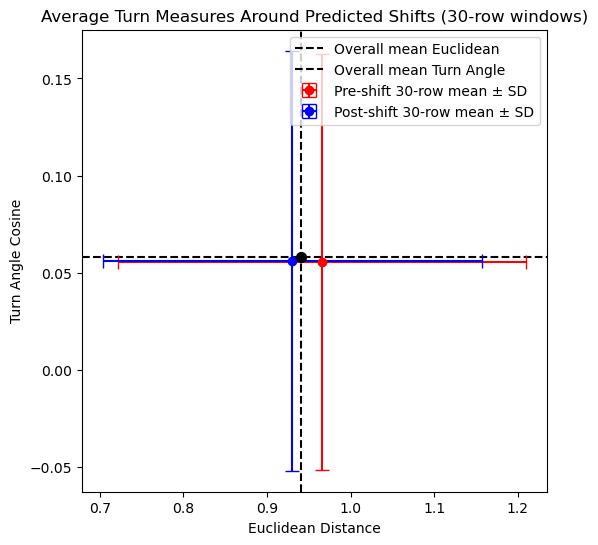

In [47]:
# --- Parameters ---
window_size = 30  # number of rows before/after predicted shift to average

pre_shift_rows = []
post_shift_rows = []

# Loop transcript-by-transcript
for tid, group in combined_df.groupby('transcript_id'):
    group = group.sort_values('time_index').reset_index(drop=True)
    predicted_idx = np.where(group['predicted_shift'] == 1)[0]
    
    # Only rows from this transcript
    df_transcript = combined_df[combined_df['transcript_id'] == tid]

    for idx in predicted_idx:

        # -------- Pre-shift window --------
        start_pre = max(0, idx - window_size)
        pre_window = group.iloc[start_pre:idx]

        for _, row in pre_window.iterrows():
            # match on transcript_id + A_start_time
            match = df_transcript[
                df_transcript['A_start_time'] == row['A_start_time']
            ]

            if not match.empty:
                pre_shift_rows.append({
                    'euclidean_distance': match['euclidean_distance'].values[0],
                    'cosine_turn': match['cosine_turn'].values[0]
                })

        # -------- Post-shift window --------
        end_post = min(len(group), idx + 1 + window_size)
        post_window = group.iloc[idx+1:end_post]

        for _, row in post_window.iterrows():
            match = df_transcript[
                df_transcript['A_start_time'] == row['A_start_time']
            ]

            if not match.empty:
                post_shift_rows.append({
                    'euclidean_distance': match['euclidean_distance'].values[0],
                    'cosine_turn': match['cosine_turn'].values[0]
                })

# Convert to DataFrames
pre_shift_df = pd.DataFrame(pre_shift_rows).dropna()
post_shift_df = pd.DataFrame(post_shift_rows).dropna()

# --- Compute summary stats ---
pre_mean_euc, pre_sd_euc = pre_shift_df['euclidean_distance'].mean(), pre_shift_df['euclidean_distance'].std()
pre_mean_cos, pre_sd_cos = pre_shift_df['cosine_turn'].mean(), pre_shift_df['cosine_turn'].std()

post_mean_euc, post_sd_euc = post_shift_df['euclidean_distance'].mean(), post_shift_df['euclidean_distance'].std()
post_mean_cos, post_sd_cos = post_shift_df['cosine_turn'].mean(), post_shift_df['cosine_turn'].std()

overall_mean_euc = combined_df['euclidean_distance'].mean()
overall_mean_cos = combined_df['cosine_turn'].mean()

# --- Plot ---
fig, ax = plt.subplots(figsize=(6,6))

# Overall mean lines
ax.axvline(overall_mean_euc, color='black', linestyle='--', label='Overall mean Euclidean')
ax.axhline(overall_mean_cos, color='black', linestyle='--', label='Overall mean Turn Angle')

# Intersection point of overall means
ax.scatter(overall_mean_euc, overall_mean_cos, color='black', s=50, zorder=5)

# Pre-shift window (mean ± SD)
ax.errorbar(
    pre_mean_euc, pre_mean_cos,
    xerr=pre_sd_euc, yerr=pre_sd_cos,
    fmt='o', color='red', ecolor='red', capsize=5,
    label=f'Pre-shift {window_size}-row mean ± SD'
)

# Post-shift window (mean ± SD)
ax.errorbar(
    post_mean_euc, post_mean_cos,
    xerr=post_sd_euc, yerr=post_sd_cos,
    fmt='o', color='blue', ecolor='blue', capsize=5,
    label=f'Post-shift {window_size}-row mean ± SD'
)

ax.set_xlabel('Euclidean Distance')
ax.set_ylabel('Turn Angle Cosine')
ax.set_title(f'Average Turn Measures Around Predicted Shifts ({window_size}-row windows)')
ax.legend()

plt.show()

In [3]:
# load test data
test = pd.read_pickle(output_dir + '/full_sample_test_10_0.pkl')
test.head()

transcript_id  window_size  gap_size  A_start_turn  \
0  0c6b3a4a-7832-44ea-8830-ff727f2b803c           10         0             1   
1  0c6b3a4a-7832-44ea-8830-ff727f2b803c           10         0             2   
2  0c6b3a4a-7832-44ea-8830-ff727f2b803c           10         0             3   
3  0c6b3a4a-7832-44ea-8830-ff727f2b803c           10         0             4   
4  0c6b3a4a-7832-44ea-8830-ff727f2b803c           10         0             5   

   A_end_turn  A_start_time  A_end_time  \
0          10         78.44      109.26   
1          11         78.94      114.05   
2          12         83.94      117.15   
3          13         85.44      128.42   
4          14         89.44      129.25   

                                        A_utterances  \
0  No, I'm good. How are you? No. Hi, how are you...   
1  No. Hi, how are you? Good thanks. Hm My name i...   
2  Good thanks. Hm My name is played to me Hi, my...   
3  Hm My name is played to me Hi, my name's Amand...   
4  Hi, my name's Amanda. and the next time you Am...   

                                        A_embeddings  B_start_turn  \
0  [[0.043410636, -0.047820907, 0.036456082, -0.0...            11   
1  [[0.02985226, -0.061524764, 0.05039503, -0.068...            12   
2  [[0.014140707, -0.060660116, 0.020614535, -0.0...            13   
3  [[0.043647487, -0.072171405, 0.02114237, -0.06...            14   
4  [[0.03821542, -0.07104956, 0.07359171, 0.00243...            15   

   B_end_turn  B_start_time  B_end_time  \
0          20        107.85      183.46   
1          21        109.34      188.86   
2          22        116.04      201.05   
3          23        117.64      201.69   
4          24        128.14      201.56   

                                        B_utterances  \
0  So what do you want to talk about? I don't kno...   
1  I don't know anything whatever. Where are you ...   
2  Where are you located? right now my wife and I...   
3  right now my wife and I are living in texas. I...   
4  So strange. I'm sorry my kid just walked in th...   

                                        B_embeddings  cosine_similarity  \
0  [[0.050596632, -0.008288313, 0.12394914, -0.00...           0.285709   
1  [[0.043200675, -0.0043664244, 0.11021309, -0.0...           0.295585   
2  [[0.053017274, -0.036885817, 0.119996354, 0.02...           0.252323   
3  [[0.023658535, -0.01906469, 0.13647155, 0.0280...           0.307421   
4  [[0.03255904, -0.0028100894, 0.11901558, 0.006...           0.409016   

   euclidean_distance  
0            1.195233  
1            1.186941  
2            1.222847  
3            1.176928  
4            1.087183

In [4]:
# load data
df = pd.read_pickle(output_dir + "/full_sample_tile_3_0.pkl")
df.head()

transcript_id  window_size  gap_size  A_start_turn  \
0  0020a0c5-1658-4747-99c1-2839e736b481            3         0             1   
1  0020a0c5-1658-4747-99c1-2839e736b481            3         0             2   
2  0020a0c5-1658-4747-99c1-2839e736b481            3         0             3   
3  0020a0c5-1658-4747-99c1-2839e736b481            3         0             4   
4  0020a0c5-1658-4747-99c1-2839e736b481            3         0             5   

   A_end_turn                                       A_utterances  \
0           3  No, I'm good. How are you? No. Hi, how are you...   
1           4  No. Hi, how are you? Good thanks. Hm My name i...   
2           5  Good thanks. Hm My name is played to me Hi, my...   
3           6  Hm My name is played to me Hi, my name's Amand...   
4           7  Hi, my name's Amanda. and the next time you Am...   

                                        A_embeddings  B_start_turn  \
0  [[0.012172122, -0.011064016, 0.06654317, 0.000...             4   
1  [[-0.0106563475, -0.06792329, 0.064656146, -0....             5   
2  [[-0.038483433, -0.0698858, 0.0062682955, -0.0...             6   
3  [[-0.03531422, -0.04561006, 0.02838244, -0.076...             7   
4  [[-0.0010068159, -0.09045196, -0.0003150229, -...             8   

   B_end_turn                                       B_utterances  \
0           6  Hm My name is played to me Hi, my name's Amand...   
1           7  Hi, my name's Amanda. and the next time you Am...   
2           8  and the next time you Amanda. All right. Does ...   
3           9  All right. Does that time start? Yeah, three o...   
4          10  right. At three. Right, What's that? Don't go ...   

                                        B_embeddings  cosine_similarity  \
0  [[-0.03531422, -0.04561006, 0.02838244, -0.076...           0.315577   
1  [[-0.0010068159, -0.09045196, -0.0003150229, -...           0.387075   
2  [[0.044995096, -0.058201604, -0.028326219, -0....           0.442343   
3  [[0.043147173, -0.042117808, -0.027217342, -0....           0.176185   
4  [[0.043233756, -0.056193333, -0.049202096, -0....           0.408750   

   euclidean_distance  
0            1.169977  
1            1.107181  
2            1.056084  
3            1.283600  
4            1.087428

In [5]:
# load all transcript raw data
all_transcripts = pd.read_csv(output_dir + "/all_transcripts.csv")
all_transcripts.head()

turn_id                   speaker  start   stop  \
0        0  5c8be0dd542fbd0016924f5f  78.44  83.36   
1        1  5f2f6bd965964e35e20c7445  78.94  81.56   
2        2  5f2f6bd965964e35e20c7445  83.94  85.26   
3        3  5c8be0dd542fbd0016924f5f  85.44  90.06   
4        4  5f2f6bd965964e35e20c7445  89.44  92.16   

                    utterance backchannel  backchannel_count  \
0  No, I'm good. How are you?         NaN                  0   
1        No. Hi, how are you?         NaN                  0   
2                Good thanks.         NaN                  0   
3  Hm My name is played to me        Mhm.                  1   
4       Hi, my name's Amanda.         NaN                  0   

        backchannel_speaker  backchannel_start  backchannel_stop  interval  \
0                       NaN                NaN               NaN     20.18   
1                       NaN                NaN               NaN     -0.31   
2                       NaN                NaN               NaN      0.58   
3  5f2f6bd965964e35e20c7445              87.74             88.76      0.18   
4                       NaN                NaN               NaN     -0.24   

   delta  questions  end_question  overlap  n_words  \
0   4.92          1          True    False        6   
1   2.62          1          True     True        5   
2   1.32          0         False    False        2   
3   4.62          0         False    False        7   
4   2.72          0         False     True        4   

                          transcript_id  
0  3a51d3fd-a343-4177-b48e-a694a14c5891  
1  3a51d3fd-a343-4177-b48e-a694a14c5891  
2  3a51d3fd-a343-4177-b48e-a694a14c5891  
3  3a51d3fd-a343-4177-b48e-a694a14c5891  
4  3a51d3fd-a343-4177-b48e-a694a14c5891

In [6]:
# get a list of transcripts annotated in the 200 dense subset
dense = pd.read_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/processed/dense_subset_processed.csv")
dense_transcripts = dense['transcript_id'].unique().tolist()

dense.head()

transcript_id  turn_id  scaled_turn_id  \
0  01849238-f5f0-487e-bca4-7b4fe0c9625c        0            0.00   
1  01849238-f5f0-487e-bca4-7b4fe0c9625c        1            0.00   
2  01849238-f5f0-487e-bca4-7b4fe0c9625c        2            0.01   
3  01849238-f5f0-487e-bca4-7b4fe0c9625c        3            0.01   
4  01849238-f5f0-487e-bca4-7b4fe0c9625c        4            0.01   

                                         PID  \
0                                        NaN   
1  [False, '66ea5116a642813c3dcf3c6f', None]   
2                                        NaN   
3                                        NaN   
4  [False, '66ea5116a642813c3dcf3c6f', None]   

                                           utterance  \
0  mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...   
1  Hello, Can you hear me? I can, how are you doing?   
2                               Good. How about you?   
3                             I am doing well, yeah,   
4  Sweet. So um I guess we could start off by tal...   

                                    currentUtterance     previous_topic  \
0                                                NaN                NaN   
1  Hello, Can you hear me? I can, how are you doing?  Starting The Call   
2                                                NaN                NaN   
3                                                NaN                NaN   
4  Sweet. So um I guess we could start off by tal...           Greeting   

       new_topic  
0            NaN  
1       Greeting  
2            NaN  
3            NaN  
4  Introductions

### Step Size & Turn Angle

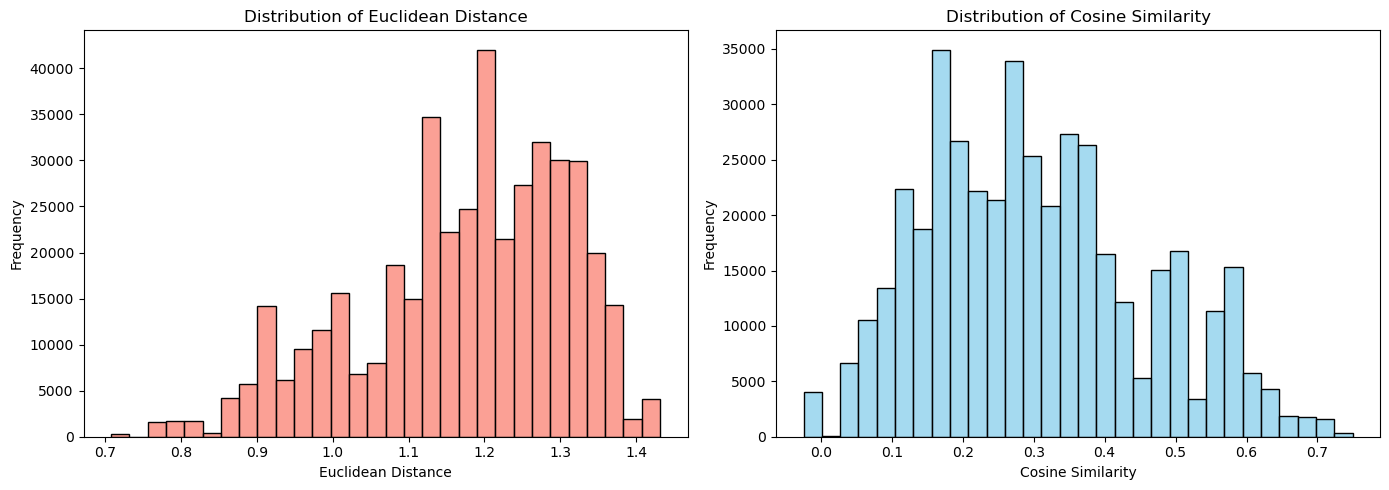

In [5]:
# plot distributions of cosine similarity and euclidean distances
# create figure / axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# plot A - step length (euclidean distance)
sns.histplot(df['euclidean_distance'], bins=30, kde=False, ax=axes[0], color='salmon')
axes[0].set_title('Distribution of Euclidean Distance')
axes[0].set_xlabel('Euclidean Distance')
axes[0].set_ylabel('Frequency')

# plot B - turn angles (cosine similarity)
sns.histplot(df['cosine_similarity'], bins=30, kde=False, ax=axes[1], color='skyblue')
axes[1].set_title('Distribution of Cosine Similarity')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')

# plot
plt.tight_layout()
plt.show()

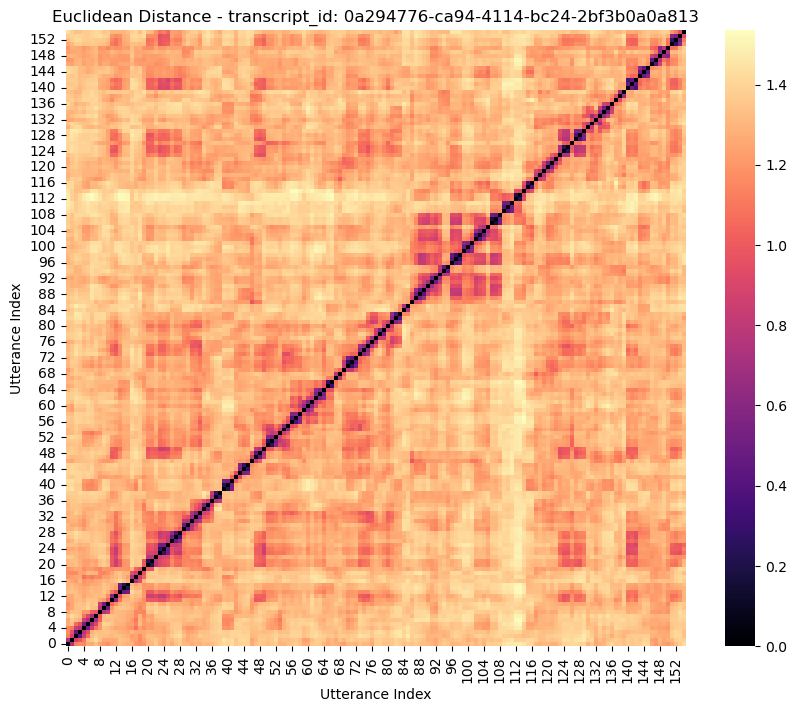

In [6]:
transcript_id = '0a294776-ca94-4114-bc24-2bf3b0a0a813'
subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)

embedding_matrix = np.vstack(subset['A_embeddings'].values)

distance_matrix = cdist(embedding_matrix, embedding_matrix, metric='euclidean')

plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=False, cmap='magma')
plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
plt.gca().invert_yaxis()
plt.xlabel('Utterance Index')
plt.ylabel('Utterance Index')
plt.show()

In [ ]:
# # test subset
# test_df = df.head(1000).copy()

# # create a folder in the full sample data output to save heatmaps
# heatmap_dir = os.path.join(output_dir, "euclidean-distance-heatmaps")
# os.makedirs(heatmap_dir, exist_ok=True)

# # loop through each unique transcript_id
# for transcript_id in df['transcript_id'].unique():
#     subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)
#     # add in skip if not enough data exists to compute distances
#     if subset.empty or subset.shape[0] < 2:
#         continue
#     try:
#         # stack embeddings into a matrix
#         embedding_matrix = np.vstack(subset['A_embeddings'].values)
#         # compute pairwise euclidean distance
#         distance_matrix = cdist(embedding_matrix, embedding_matrix, metric = "euclidean")
#         # plot heatmap
#         plt.figure(figsize=(10, 8))
#         sns.heatmap(distance_matrix, annot=False, cmap='magma')
#         plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
#         plt.gca().invert_yaxis()
#         plt.xlabel('Utterance Index')
#         plt.ylabel('Utterance Index')
#         # save each plot
#         save_id = transcript_id.replace('/', '_')  # edit ID in case there are problematic characters
#         plot_path = os.path.join(heatmap_dir, f"{save_id}.png")
#         plt.savefig(plot_path, bbox_inches='tight')
#         plt.close()

#     except Exception as e:
#         print(f"Error creating heatmap for {transcript_id}: {e}")

In [ ]:
# # test subset
# test_df = df.head(1000).copy()

# # create a folder in the full sample data output to save heatmaps
# heatmap_dir = os.path.join(output_dir, "cosine-similarity-heatmaps")
# os.makedirs(heatmap_dir, exist_ok=True)

# # loop through each unique transcript_id
# for transcript_id in df['transcript_id'].unique():
#     subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)
#     # add in skip if not enough data exists to compute distances
#     if subset.empty or subset.shape[0] < 2:
#         continue
#     try:
#         # stack embeddings into a matrix
#         embedding_matrix = np.vstack(subset['A_embeddings'].values)
#         # compute pairwise cosine similarity
#         distance_matrix = cdist(embedding_matrix, embedding_matrix, metric = "cosine")
#         # plot heatmap
#         plt.figure(figsize=(10, 8))
#         sns.heatmap(distance_matrix, annot=False, cmap='magma')
#         plt.title(f'Cosine Similarity - transcript_id: {transcript_id}')
#         plt.gca().invert_yaxis()
#         plt.xlabel('Utterance Index')
#         plt.ylabel('Utterance Index')
#         # save each plot
#         save_id = transcript_id.replace('/', '_')  # edit ID in case there are problematic characters
#         plot_path = os.path.join(heatmap_dir, f"{save_id}.png")
#         plt.savefig(plot_path, bbox_inches='tight')
#         plt.close()

#     except Exception as e:
#         print(f"Error creating heatmap for {transcript_id}: {e}")

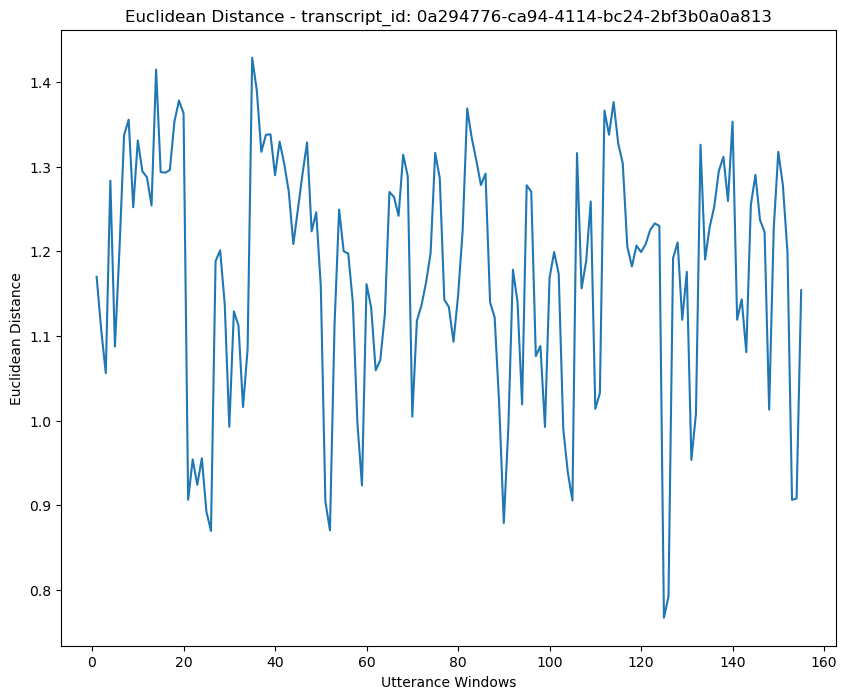

In [7]:
# plot a conversation's peaks of euclidean distances and cosine similarities
transcript_id = '0a294776-ca94-4114-bc24-2bf3b0a0a813'
#transcript_id = '339012e4-ada1-4c88-839d-08a6842b5903'
subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.lineplot(data=subset, x='A_start_turn', y='euclidean_distance')
plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
plt.xlabel('Utterance Windows')
plt.ylabel('Euclidean Distance')
plt.show()

## Foote Novelty

In [7]:
# foote novelty
# testing data set = test; full = df

all_results = []

for transcript_id, group in test.groupby('transcript_id'):
    # sort by conversation order within each transcript
    group = group.sort_values('A_start_turn').reset_index(drop=True)
    
    # construct full embedding trajectory (starting with first A_embeddings and ending with last B_embeddings)
    embeddings_list = [emb.squeeze() for emb in group['A_embeddings'].values]
    embeddings_list.append(group['B_embeddings'].values[-1].squeeze())
    embeddings = np.vstack(embeddings_list)
    n = embeddings.shape[0]
    if n < 4:
        continue

    # compute the self-similarity matrix (how similar is each embedding to all other embeddings in the convo?)
    # https://ccrma.stanford.edu/workshops/mir2009/references/Foote_00.pdf 
    S = cosine_similarity(embeddings)

    # build the checkerboard kernel
    # thanks GPT for help actually making the checkerboard kernel
    kernel_size = 10  # bigger values = detect larger shifts
    k = kernel_size // 2
    kernel = np.block([
        [np.ones((k, k)), -np.ones((k, k))],
        [-np.ones((k, k)), np.ones((k, k))]
    ])
    kernel = kernel / np.sqrt((kernel_size ** 2) / 2)

    # compute foote novelty
    novelty = np.zeros(n)
    for i in range(k, n - k):
        sub = S[i - k:i + k, i - k:i + k]
        novelty[i] = np.sum(sub * kernel)

    # normalize the novelty scores to 0-1
    novelty = (novelty - novelty.min()) / (novelty.max() - novelty.min() + 1e-8)

    # save results
    temp = pd.DataFrame({
        'transcript_id': transcript_id,
        'turn_index': np.arange(n),   # each embedding position
        'foote_novelty': novelty
    })
    all_results.append(temp)

# Combine all transcripts
foote_df_10 = pd.concat(all_results, ignore_index=True)

In [8]:
# larger shifts
all_results = []

for transcript_id, group in test.groupby('transcript_id'):
    # sort by conversation order within each transcript
    group = group.sort_values('A_start_turn').reset_index(drop=True)
    
    # construct full embedding trajectory (starting with first A_embeddings and ending with last B_embeddings)
    embeddings_list = [emb.squeeze() for emb in group['A_embeddings'].values]
    embeddings_list.append(group['B_embeddings'].values[-1].squeeze())
    embeddings = np.vstack(embeddings_list)
    n = embeddings.shape[0]
    if n < 4:
        continue

    # compute the self-similarity matrix (how similar is each embedding to all other embeddings in the convo?)
    # https://ccrma.stanford.edu/workshops/mir2009/references/Foote_00.pdf 
    S = cosine_similarity(embeddings)

    # build the checkerboard kernel
    # thanks GPT for help actually making the checkerboard kernel
    kernel_size = 20  # bigger values = detect larger shifts
    k = kernel_size // 2
    kernel = np.block([
        [np.ones((k, k)), -np.ones((k, k))],
        [-np.ones((k, k)), np.ones((k, k))]
    ])
    kernel = kernel / np.sqrt((kernel_size ** 2) / 2)

    # compute foote novelty
    novelty = np.zeros(n)
    for i in range(k, n - k):
        sub = S[i - k:i + k, i - k:i + k]
        novelty[i] = np.sum(sub * kernel)

    # normalize the novelty scores to 0-1
    novelty = (novelty - novelty.min()) / (novelty.max() - novelty.min() + 1e-8)

    # save results
    temp = pd.DataFrame({
        'transcript_id': transcript_id,
        'turn_index': np.arange(n),   # each embedding position
        'foote_novelty': novelty
    })
    all_results.append(temp)

# Combine all transcripts
foote_df_20 = pd.concat(all_results, ignore_index=True)

In [10]:
# mark predicted shifts when foote novelty is 1.5 SD away from transcript mean foote novelty
# HELEN TO CHECK: DO WE WANT THRESHOLD TO BE MORE LOCAL??
foote_df_10['predicted_shift'] = 0

for tid, group in foote_df_10.groupby('transcript_id'):
    mean_nov = group['foote_novelty'].mean()
    std_nov  = group['foote_novelty'].std()
    threshold = mean_nov + 1.5 * std_nov
    
    # mark points above threshold
    idx = group.index[group['foote_novelty'] > threshold]
    foote_df_10.loc[idx, 'predicted_shift'] = 1

foote_df_20['predicted_shift'] = 0

for tid, group in foote_df_20.groupby('transcript_id'):
    mean_nov = group['foote_novelty'].mean()
    std_nov  = group['foote_novelty'].std()
    threshold = mean_nov + 1.5 * std_nov
    
    # mark points above threshold
    idx = group.index[group['foote_novelty'] > threshold]
    foote_df_20.loc[idx, 'predicted_shift'] = 1

In [16]:
# preview
foote_df_20.head()

transcript_id  turn_index  foote_novelty  \
0  0c6b3a4a-7832-44ea-8830-ff727f2b803c           0            0.0   
1  0c6b3a4a-7832-44ea-8830-ff727f2b803c           1            0.0   
2  0c6b3a4a-7832-44ea-8830-ff727f2b803c           2            0.0   
3  0c6b3a4a-7832-44ea-8830-ff727f2b803c           3            0.0   
4  0c6b3a4a-7832-44ea-8830-ff727f2b803c           4            0.0   

   predicted_shift  
0                0  
1                0  
2                0  
3                0  
4                0

/var/folders/vj/qkpl_dxs7fd3f2nl6_9794n00000gn/T/ipykernel_44881/3581075628.py:20: RuntimeWarning: Mean of empty slice.
  threshold_10 = nov_vals_10.mean() + 1.5 * nov_vals_10.std()
/opt/anaconda3/envs/myenv-python3-11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/myenv-python3-11/lib/python3.11/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/myenv-python3-11/lib/python3.11/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/envs/myenv-python3-11/lib/python3.11/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/v

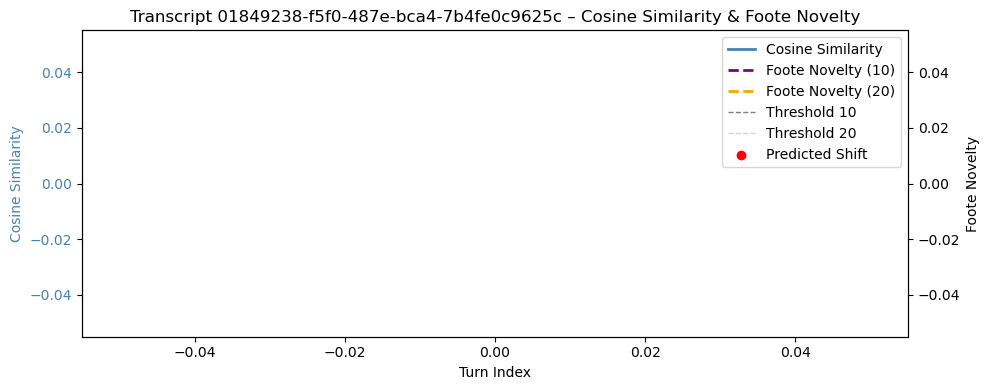

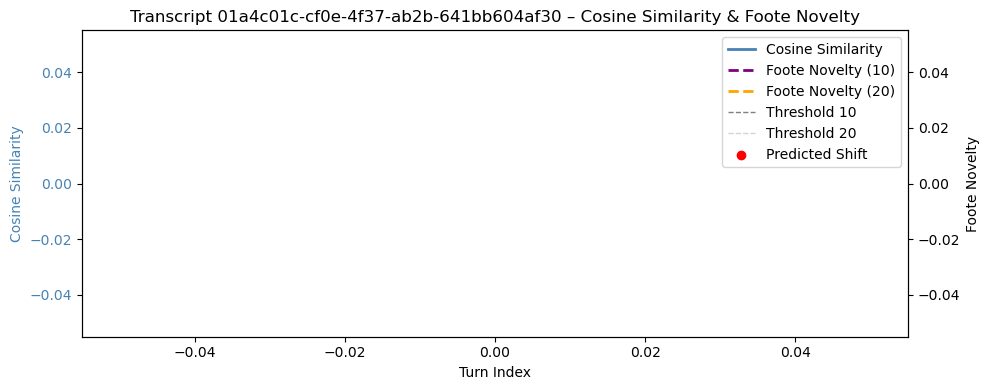

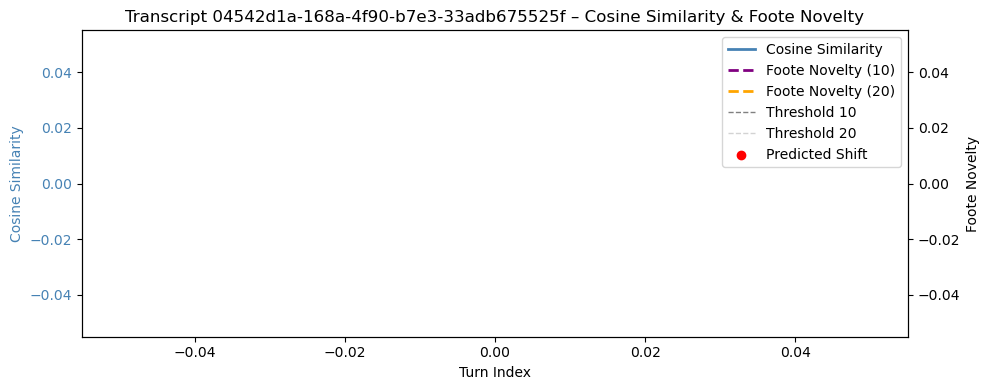

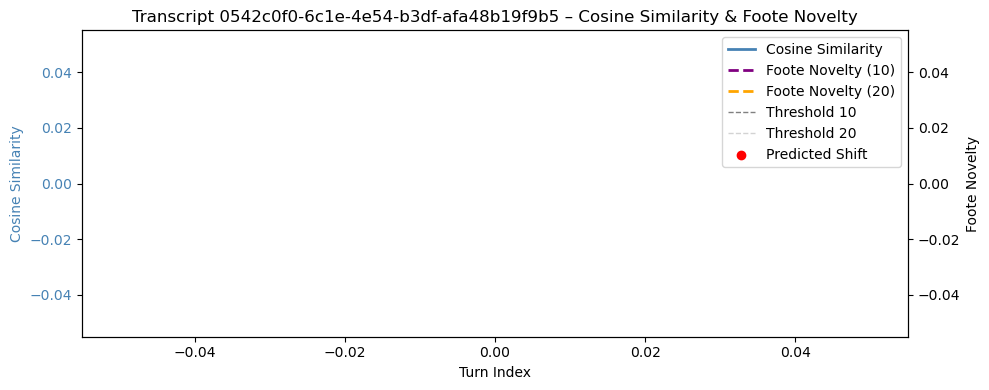

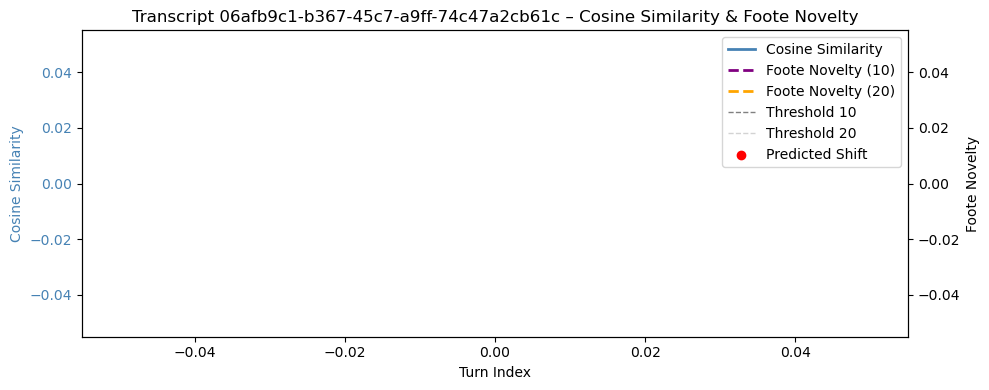

In [17]:
# plot 5 densely annotated transcripts showing cosine similarity and foote novelty (10 and 20)
unique_transcripts = dense['transcript_id'].unique().tolist()
example_transcripts = unique_transcripts[:5]

for tid in example_transcripts:
    # Select and sort data
    cos_df = df[df['transcript_id'] == tid].sort_values('A_start_turn').reset_index(drop=True)
    nov_df_10 = foote_df_10[foote_df_10['transcript_id'] == tid]
    nov_df_20 = foote_df_20[foote_df_20['transcript_id'] == tid]

    # Align lengths
    min_len = min(len(cos_df), len(nov_df_10), len(nov_df_20))
    turns = np.arange(min_len)
    cos_vals = cos_df['cosine_similarity'].values[:min_len]
    nov_vals_10 = nov_df_10['foote_novelty'].values[:min_len]
    nov_vals_20 = nov_df_20['foote_novelty'].values[:min_len]
    predicted_10 = np.array(nov_df_10['predicted_shift'].values[:min_len])

    # Compute thresholds
    threshold_10 = nov_vals_10.mean() + 1.5 * nov_vals_10.std()
    threshold_20 = nov_vals_20.mean() + 1.5 * nov_vals_20.std()

    # Plot
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Cosine Similarity (left y-axis)
    ax1.plot(turns, cos_vals, color='steelblue', lw=2, label='Cosine Similarity')
    ax1.set_xlabel('Turn Index')
    ax1.set_ylabel('Cosine Similarity', color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')

    # Foote novelty (right y-axis)
    ax2 = ax1.twinx()
    ax2.plot(turns, nov_vals_10, color='purple', linestyle='--', lw=2, label='Foote Novelty (10)')
    ax2.plot(turns, nov_vals_20, color='orange', linestyle='--', lw=2, label='Foote Novelty (20)')
    ax2.axhline(threshold_10, color='gray', ls='--', lw=1, label='Threshold 10')
    ax2.axhline(threshold_20, color='lightgray', ls='--', lw=1, label='Threshold 20')
    ax2.scatter(turns[predicted_10==1], nov_vals_10[predicted_10==1], color='red', zorder=5, label='Predicted Shift')
    ax2.set_ylabel('Foote Novelty', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.title(f'Transcript {tid} – Cosine Similarity & Foote Novelty')
    fig.tight_layout()
    plt.show()

/var/folders/vj/qkpl_dxs7fd3f2nl6_9794n00000gn/T/ipykernel_44881/3883135357.py:27: RuntimeWarning: Mean of empty slice.
  threshold_10 = nov_vals_10.mean() + 1.5 * nov_vals_10.std()
/opt/anaconda3/envs/myenv-python3-11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/myenv-python3-11/lib/python3.11/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/myenv-python3-11/lib/python3.11/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/envs/myenv-python3-11/lib/python3.11/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/v

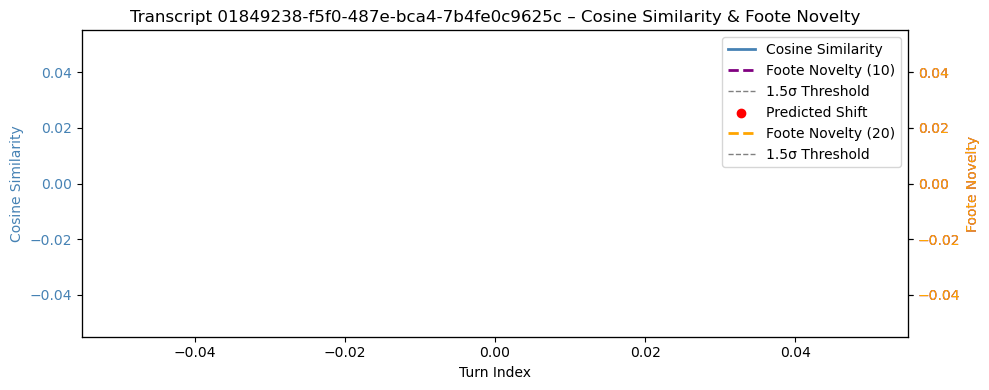

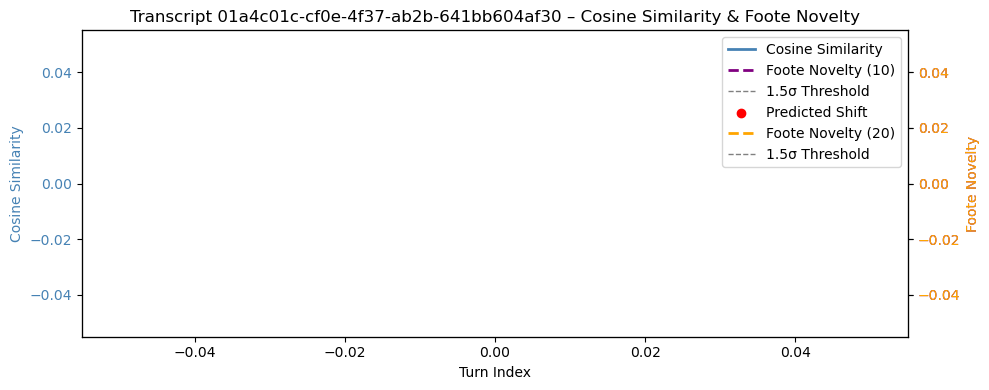

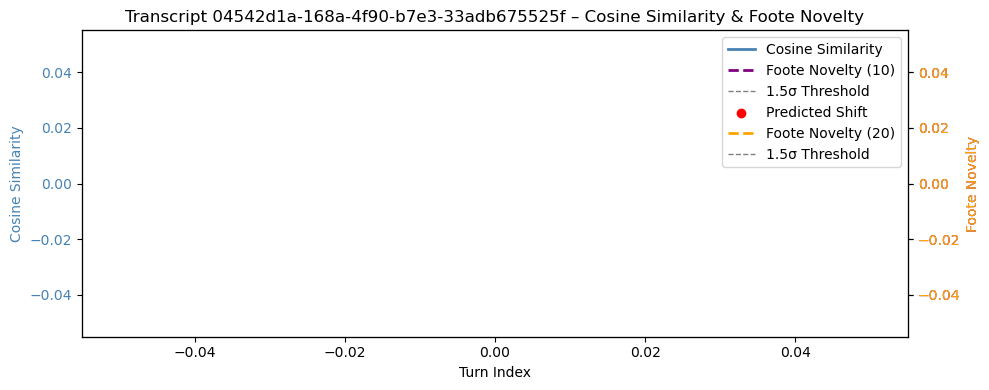

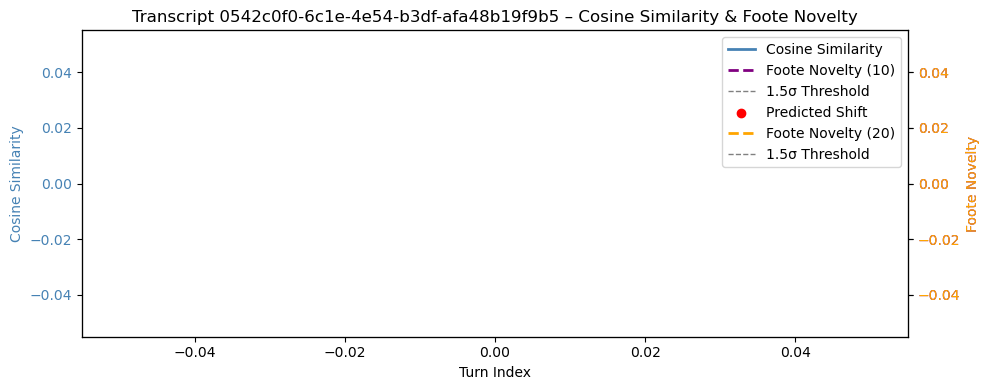

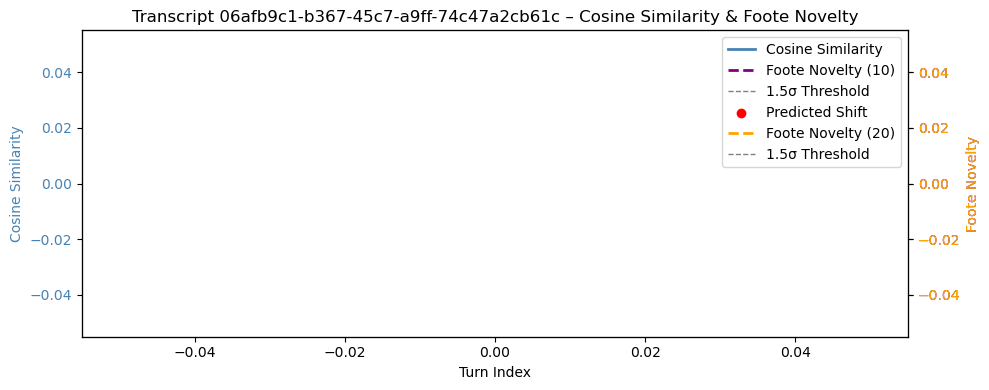

In [13]:
# plot 5 densely annotated transcripts showing cosine similarity and foote novelty (10 and 20)
unique_transcripts = dense['transcript_id'].unique().tolist()
example_transcripts = unique_transcripts[:5]

for tid in example_transcripts:
    # get cosine similarity from original df
    cos_df = df[df['transcript_id'] == tid].sort_values('A_start_turn').reset_index(drop=True)
    
    # get Foote novelty from foote_df
    nov_df_10 = foote_df_10[foote_df_10['transcript_id'] == tid]
    nov_df_20 = foote_df_20[foote_df_20['transcript_id'] == tid]
    
    # align lengths in case they differ
    min_len = min(len(cos_df), len(nov_df_10))
    cos_vals = cos_df['cosine_similarity'].values[:min_len]
    nov_vals_10 = nov_df_10['foote_novelty'].values[:min_len]
    predicted_10 = nov_df_10['predicted_shift'].values[:min_len]
    turns_10 = np.arange(min_len)

    min_len = min(len(cos_df), len(nov_df_20))
    cos_vals = cos_df['cosine_similarity'].values[:min_len]
    nov_vals_20 = nov_df_20['foote_novelty'].values[:min_len]
    predicted_20 = nov_df_20['predicted_shift'].values[:min_len]
    turns_20 = np.arange(min_len)
    
    # compute threshold for this transcript (mean + 1.5 * std)
    threshold_10 = nov_vals_10.mean() + 1.5 * nov_vals_10.std()
    threshold_20 = nov_vals_20.mean() + 1.5 * nov_vals_20.std()
    
    # plot
    fig, ax1 = plt.subplots(figsize=(10, 4))
    
    # cosine similarity (left y-axis)
    ax1.plot(turns_10, cos_vals, color='steelblue', lw=2, label='Cosine Similarity')
    ax1.set_xlabel('Turn Index')
    ax1.set_ylabel('Cosine Similarity', color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')
    
    # foote novelty (right y-axis) 10
    ax2 = ax1.twinx()
    ax2.plot(turns_10, nov_vals_10, color='purple', linestyle='--', lw=2, label='Foote Novelty (10)')
    ax2.axhline(threshold_10, color='gray', ls='--', lw=1, label='1.5σ Threshold')
    ax2.set_ylabel('Foote Novelty', color='purple')
    ax2.tick_params(axis='y', labelcolor='purple')

    # foote novelty (right y-axis) 20
    ax3 = ax1.twinx()
    ax3.plot(turns_20, nov_vals_20, color='orange', linestyle='--', lw=2, label='Foote Novelty (20)')
    ax3.axhline(threshold_20, color='gray', ls='--', lw=1, label='1.5σ Threshold')
    ax3.set_ylabel('Foote Novelty', color='orange')
    ax3.tick_params(axis='y', labelcolor='orange')
    
    # mark predicted shift peaks
    peak_idx = np.where(predicted_10 == 1)[0]
    ax2.scatter(turns_10[peak_idx], nov_vals_10[peak_idx], color='red', zorder=5, label='Predicted Shift')
    
    plt.title(f'Transcript {tid} – Cosine Similarity & Foote Novelty')
    fig.tight_layout()
    
    # combine legends and plot
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper right')
    
    plt.show()


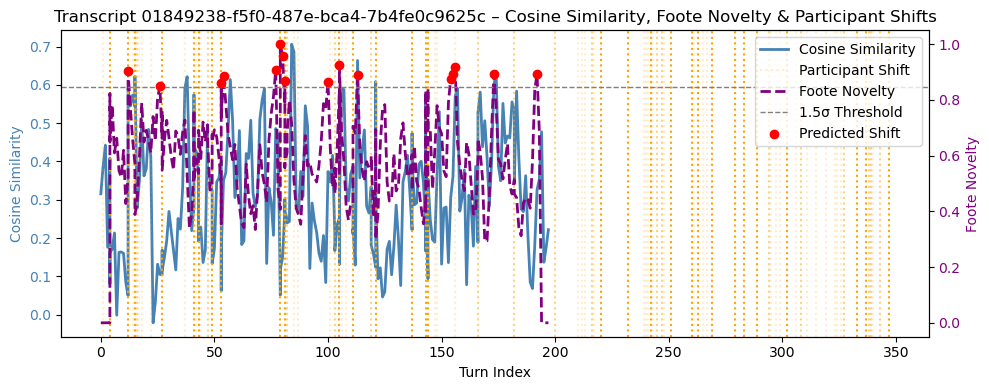

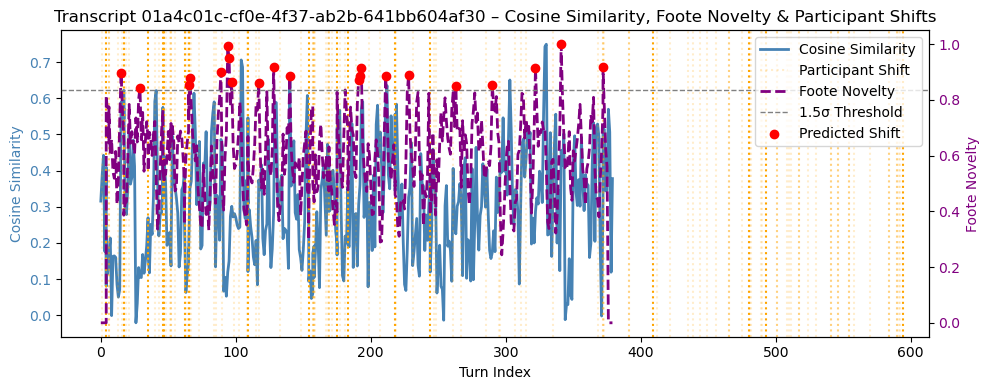

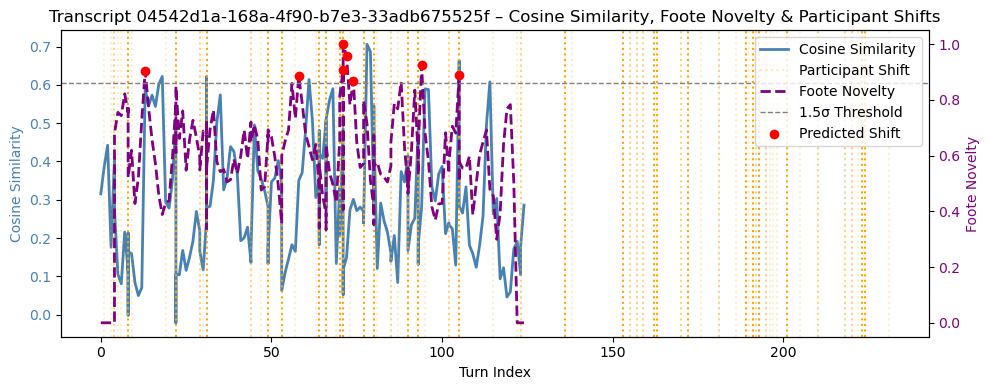

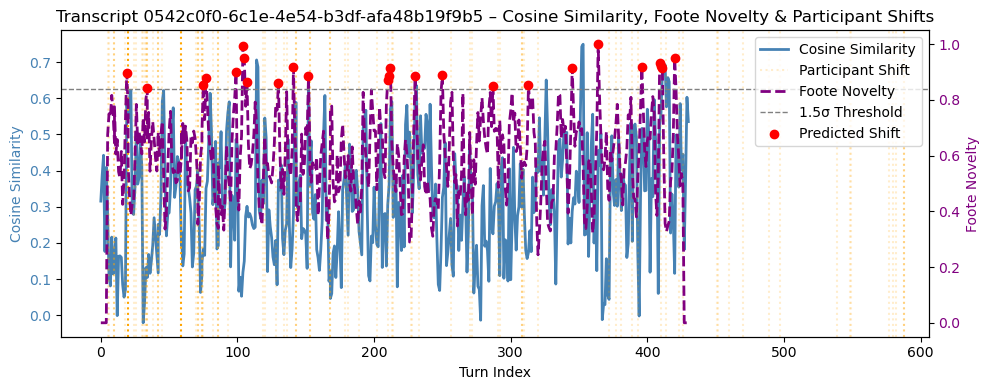

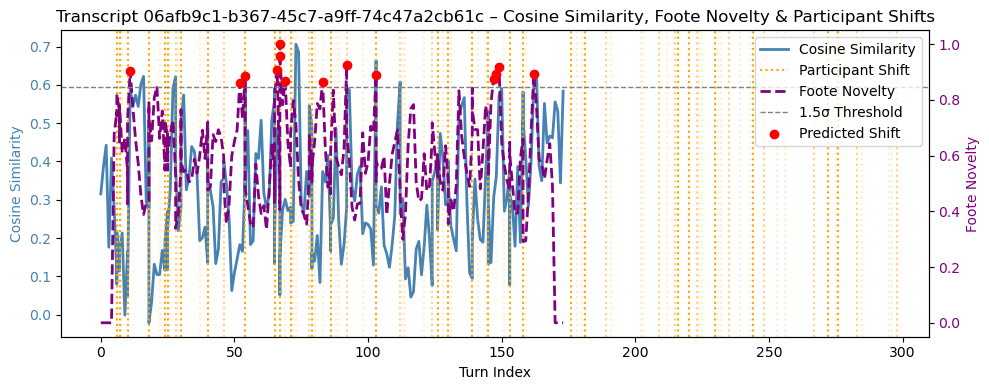

In [20]:
# now overlap the foote novelty and cosine similarity with participant annotations
example_transcripts = dense['transcript_id'].unique()[:5]

for tid in example_transcripts:
    # get cosine similarity values from 3 tiled windows
    cos_df = df[df['transcript_id'] == tid].sort_values('A_start_turn').reset_index(drop=True)
    
    # get foote novelty from new foote_df data frame
    nov_df = foote_df[foote_df['transcript_id'] == tid].copy()
    
    # map novelty points to the first turn in their 3-utterance cluster (to account for A_start_turn etc)
    nov_df['plot_turn'] = nov_df['turn_index'].map(
        dict(zip(range(len(dense[dense['transcript_id']==tid])), 
                 dense[dense['transcript_id']==tid]['turn_id'])))
    
    # align lengths
    min_len = min(len(cos_df), len(nov_df))
    cos_vals = cos_df['cosine_similarity'].values[:min_len]
    nov_vals = nov_df['foote_novelty'].values[:min_len]
    predicted = nov_df['predicted_shift'].values[:min_len]
    turns = nov_df['plot_turn'].values[:min_len]  # use the mapped turn IDs for x-axis
    
    # determine the threshold for plotting
    threshold = nov_vals.mean() + 1.5 * nov_vals.std()
    
    # get participant annotations
    dense_transcript = dense[dense['transcript_id'] == tid]
    shift_counts = dense_transcript.groupby('turn_id')['new_topic'].apply(lambda x: x.notnull().sum())
    shift_counts = shift_counts[shift_counts > 0]  # only turns with at least 1 participant
    
    # keep only shifts within plotted range
    # triple check this, not sure it's doing what I want...
    #shift_counts = shift_counts[shift_counts.index.isin(turns)]
    
    # plot!
    fig, ax1 = plt.subplots(figsize=(10,4))
    
    # cosine similarity
    ax1.plot(turns, cos_vals, color='steelblue', lw=2, label='Cosine Similarity')
    ax1.set_xlabel('Turn Index')
    ax1.set_ylabel('Cosine Similarity', color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')
    
    # foote novelty
    ax2 = ax1.twinx()
    ax2.plot(turns, nov_vals, color='purple', linestyle='--', lw=2, label='Foote Novelty')
    ax2.axhline(threshold, color='gray', ls='--', lw=1, label='1.5σ Threshold')
    ax2.set_ylabel('Foote Novelty', color='purple')
    ax2.tick_params(axis='y', labelcolor='purple')
    
    # points of predicted shifts
    peak_idx = np.where(predicted == 1)[0]
    ax2.scatter(turns[peak_idx], nov_vals[peak_idx], color='red', zorder=5, label='Predicted Shift')
    
    # participant-determined topic shifts with alpha for number of annotators
    plotted_first = False
    for turn, count in shift_counts.items():
        alpha = 0.2 if count == 1 else 0.5 if count == 2 else 1.0
        ax1.axvline(x=turn, color='orange', linestyle=':', lw=1.5,
                    alpha=alpha, label='Participant Shift' if not plotted_first else "")
        plotted_first = True
    
    # create title and legend
    plt.title(f'Transcript {tid} – Cosine Similarity, Foote Novelty & Participant Shifts')
    fig.tight_layout()
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    
    plt.show()



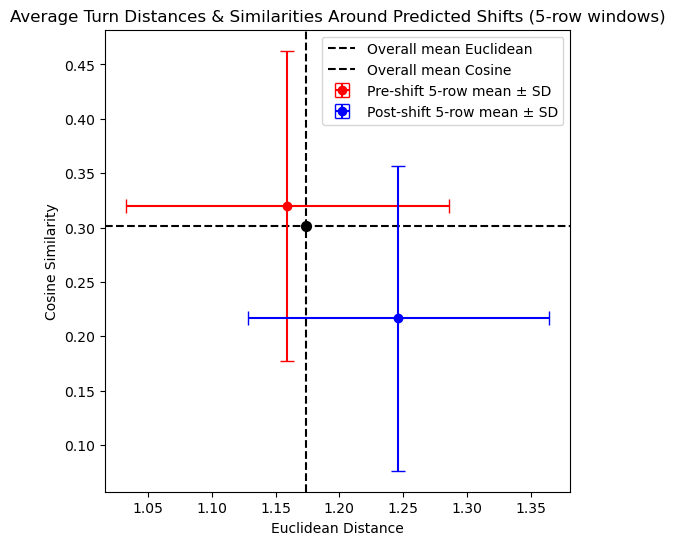

In [18]:
# now get the average turn angle and step length overall and for utterances before and after predicted shifts

window_size = 5  # number of rows before/after predicted shift to average

pre_shift_rows = []
post_shift_rows = []

for tid, group in foote_df.groupby('transcript_id'):
    group = group.sort_values('turn_index').reset_index(drop=True)
    predicted_idx = np.where(group['predicted_shift'] == 1)[0]
    
    df_transcript = df[df['transcript_id'] == tid]
    
    for idx in predicted_idx:
        # --- Pre-shift window ---
        start_pre = max(0, idx - window_size)
        pre_window = group.iloc[start_pre:idx]
        
        for _, row in pre_window.iterrows():
            match = df_transcript[(df_transcript['A_start_turn'] <= row['turn_index']) &
                                  (df_transcript['B_end_turn'] >= row['turn_index'])]
            if not match.empty:
                pre_shift_rows.append({
                    'euclidean_distance': match['euclidean_distance'].values[0],
                    'cosine_similarity': match['cosine_similarity'].values[0]
                })
        
        # --- Post-shift window ---
        end_post = min(len(group), idx + 1 + window_size)
        post_window = group.iloc[idx+1:end_post]
        
        for _, row in post_window.iterrows():
            match = df_transcript[(df_transcript['A_start_turn'] <= row['turn_index']) &
                                  (df_transcript['B_end_turn'] >= row['turn_index'])]
            if not match.empty:
                post_shift_rows.append({
                    'euclidean_distance': match['euclidean_distance'].values[0],
                    'cosine_similarity': match['cosine_similarity'].values[0]
                })

# Combine into DataFrames
pre_shift_df = pd.DataFrame(pre_shift_rows).dropna()
post_shift_df = pd.DataFrame(post_shift_rows).dropna()

# Compute mean and SD
pre_mean_euc, pre_sd_euc = pre_shift_df['euclidean_distance'].mean(), pre_shift_df['euclidean_distance'].std()
pre_mean_cos, pre_sd_cos = pre_shift_df['cosine_similarity'].mean(), pre_shift_df['cosine_similarity'].std()

post_mean_euc, post_sd_euc = post_shift_df['euclidean_distance'].mean(), post_shift_df['euclidean_distance'].std()
post_mean_cos, post_sd_cos = post_shift_df['cosine_similarity'].mean(), post_shift_df['cosine_similarity'].std()

# --- Plot ---
fig, ax = plt.subplots(figsize=(6,6))

# Overall mean lines
ax.axvline(df['euclidean_distance'].mean(), color='black', linestyle='--', label='Overall mean Euclidean')
ax.axhline(df['cosine_similarity'].mean(), color='black', linestyle='--', label='Overall mean Cosine')

# Intersection point
ax.scatter(df['euclidean_distance'].mean(), df['cosine_similarity'].mean(), color='black', s=50, zorder=5)

# Pre-shift window mean ± SD
ax.errorbar(pre_mean_euc, pre_mean_cos,
            xerr=pre_sd_euc, yerr=pre_sd_cos,
            fmt='o', color='red', ecolor='red', capsize=5,
            label=f'Pre-shift {window_size}-row mean ± SD')

# Post-shift window mean ± SD
ax.errorbar(post_mean_euc, post_mean_cos,
            xerr=post_sd_euc, yerr=post_sd_cos,
            fmt='o', color='blue', ecolor='blue', capsize=5,
            label=f'Post-shift {window_size}-row mean ± SD')

ax.set_xlabel('Euclidean Distance')
ax.set_ylabel('Cosine Similarity')
ax.set_title(f'Average Turn Distances & Similarities Around Predicted Shifts ({window_size}-row windows)')
ax.legend()
plt.show()



## Cosine of the turn angle

Cosine angle ≈ 0 --> 

In [4]:
def compute_turn_angles_adjacent_windows(df):
    results = []

    # group by transcript
    for transcript_id, group in df.groupby('transcript_id'):
        if len(group) < 2:
            continue  # need at least 2 windows to compute a turn
        
        # stack the embeddings to ensure 2D arrays (number of points, embedding dimension)
        A = np.vstack([emb.squeeze() for emb in group['A_embeddings'].values[:-1]])
        B = np.vstack([emb.squeeze() for emb in group['B_embeddings'].values[:-1]])
        C = np.vstack([emb.squeeze() for emb in group['B_embeddings'].values[1:]])
        
        # compute vectors from the middle point (B)
        BA = A - B
        BC = C - B
        
        # calculate cosine similarity
        cos_theta = np.array([cosine_similarity(BA[i].reshape(1,-1), BC[i].reshape(1,-1))[0,0]
                              for i in range(len(BA))])
        
        # save results for this transcript
        res_df = pd.DataFrame({
            'transcript_id': transcript_id,
            'turn_index': np.arange(len(cos_theta)),  # starts at 0
            'cosine_turn': cos_theta
        })
        results.append(res_df)
    
    # combine all transcripts
    return pd.concat(results, ignore_index=True)


In [5]:
angles_df = compute_turn_angles_adjacent_windows(df)
print(angles_df.head())

                          transcript_id  turn_index  cosine_turn
0  0020a0c5-1658-4747-99c1-2839e736b481           0     0.358939
1  0020a0c5-1658-4747-99c1-2839e736b481           1    -0.267124
2  0020a0c5-1658-4747-99c1-2839e736b481           2    -0.091360
3  0020a0c5-1658-4747-99c1-2839e736b481           3     0.196351
4  0020a0c5-1658-4747-99c1-2839e736b481           4     0.332365


In [ ]:
def compute_foote_novelty(embeddings, kernel_size=10):
    """
    Compute Foote novelty curve from a sequence of embeddings.

    embeddings: np.ndarray of shape (n_turns, embedding_dim)
    kernel_size: int, must be even, controls local window width
    """
    n = len(embeddings)
    if n < kernel_size:
        return np.zeros(n)

    # Step 1: Compute self-similarity matrix (cosine)
    S = cosine_similarity(embeddings)
    
    # Step 2: Build checkerboard kernel
    k = kernel_size // 2
    kernel = np.block([
        [np.ones((k, k)), -np.ones((k, k))],
        [-np.ones((k, k)), np.ones((k, k))]
    ])
    
    # Normalize kernel
    kernel = kernel / np.sqrt((kernel_size ** 2) / 2)
    
    # Step 3: Convolve along the main diagonal
    novelty = np.zeros(n)
    for i in range(k, n - k):
        sub = S[i - k:i + k, i - k:i + k]
        novelty[i] = np.sum(sub * kernel)
    
    # Normalize to [0,1]
    novelty = (novelty - novelty.min()) / (novelty.max() - novelty.min() + 1e-8)
    return novelty


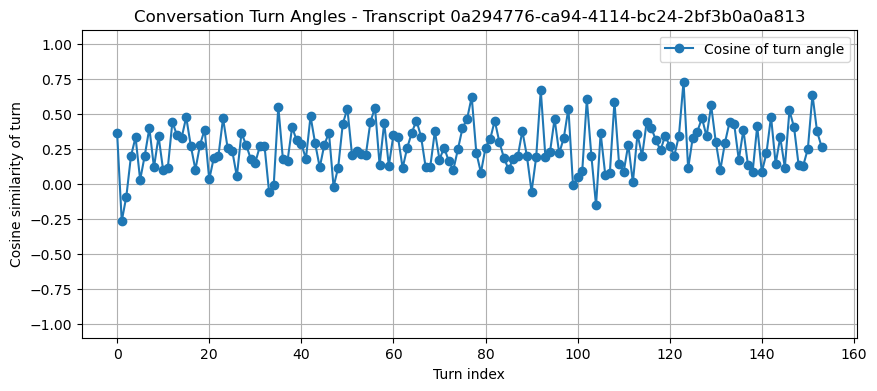

In [25]:
example_transcript = "0a294776-ca94-4114-bc24-2bf3b0a0a813"
example_df = angles_df[angles_df['transcript_id'] == example_transcript]

# Plot cosine of turn angles
plt.figure(figsize=(10, 4))
plt.plot(example_df['turn_index'], example_df['cosine_turn'], marker='o', label='Cosine of turn angle')
plt.title(f"Conversation Turn Angles - Transcript {example_transcript}")
plt.xlabel("Turn index")
plt.ylabel("Cosine similarity of turn")
plt.ylim(-1.1, 1.1)
plt.grid(True)
plt.legend()
plt.show()


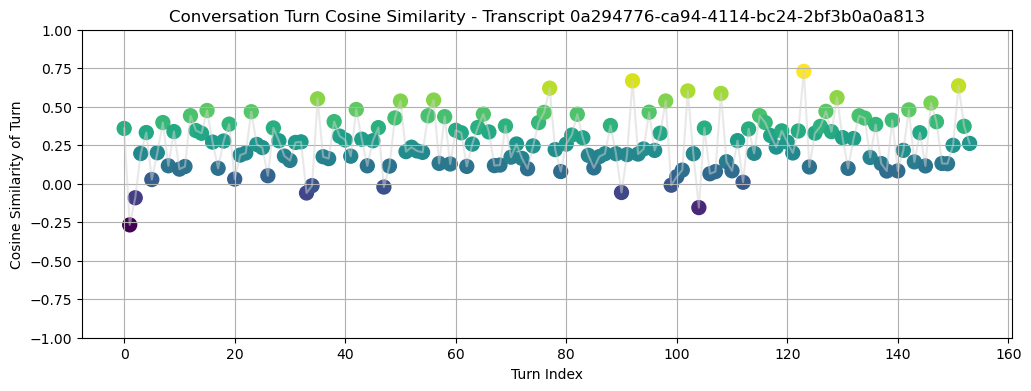

In [27]:
import matplotlib.cm as cm

example_transcript = "0a294776-ca94-4114-bc24-2bf3b0a0a813"
example_df = angles_df[angles_df['transcript_id'] == example_transcript]

norm = (example_df['cosine_turn'] - example_df['cosine_turn'].min()) / \
       (example_df['cosine_turn'].max() - example_df['cosine_turn'].min())
colors = cm.viridis(norm)

plt.figure(figsize=(12, 4))
plt.scatter(example_df['turn_index'], example_df['cosine_turn'], c=colors, s=100)
plt.plot(example_df['turn_index'], example_df['cosine_turn'], color='lightgray', alpha=0.5)
plt.xlabel("Turn Index")
plt.ylabel("Cosine Similarity of Turn")
plt.title(f"Conversation Turn Cosine Similarity - Transcript {example_transcript}")
plt.ylim(-1, 1)
plt.grid(True)
plt.show()

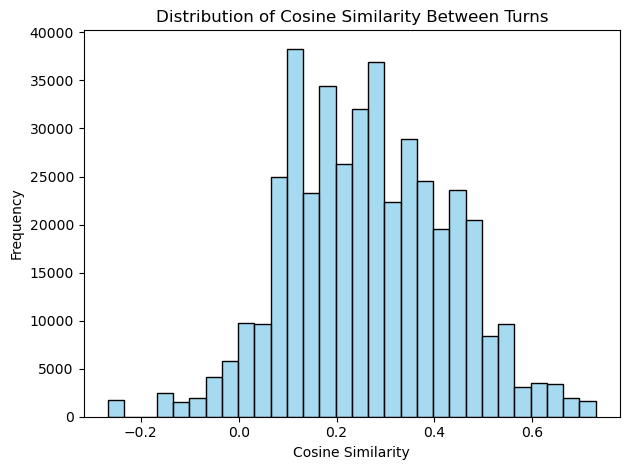

In [33]:
# distribution of cosine of turn similarity
sns.histplot(angles_df['cosine_turn'], bins=30, kde=False, color='skyblue')
plt.title('Distribution of Cosine Similarity Between Turns')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# plot
plt.tight_layout()
plt.show()

In [ ]:
# what's the cosine similarity of turn angles in the bottom 10% of the data?
threshold = np.percentile(angles_df['cosine_turn'], 10)
print("Threshold for large jumps (10th percentile):", threshold)
# cosine similarities lower than 0.079 are considered "big jumps"

Threshold for large jumps (10th percentile): 0.0790984183549881


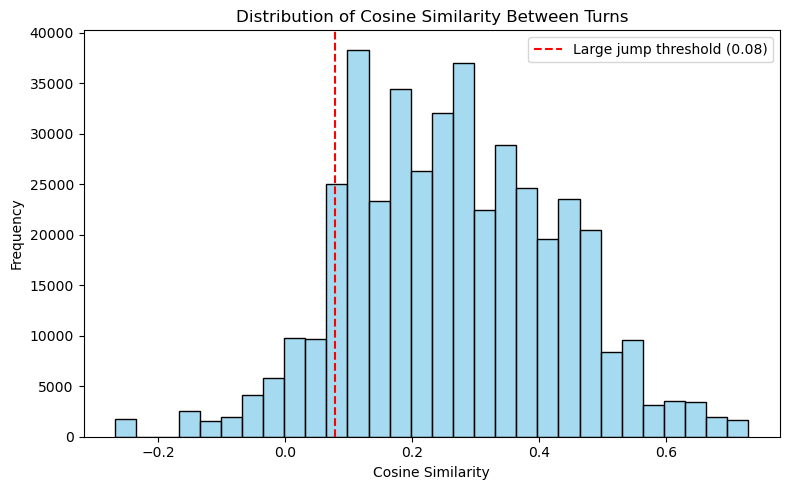

In [35]:
plt.figure(figsize=(8, 5))
sns.histplot(angles_df['cosine_turn'], bins=30, kde=False, color='skyblue')
plt.axvline(threshold, color='red', linestyle='--', label=f'Large jump threshold ({threshold:.2f})')
plt.title('Distribution of Cosine Similarity Between Turns')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
example_transcript = angles_df['transcript_id'].iloc[0]
example_df = angles_df[angles_df['transcript_id'] == example_transcript].copy()

# Threshold for large jumps
threshold = np.percentile(angles_df['cosine_turn'], 10)
example_df['large_jump'] = example_df['cosine_turn'] < threshold

# Correctly assign turn_index aligned to the example transcript
example_df['turn_index'] = df.loc[df['transcript_id'] == example_transcript, 'A_start_turn'].iloc[1:1+len(example_df)].values

# Merge utterances
example_df = example_df.merge(
    df[['transcript_id', 'A_start_turn', 'A_utterances']],
    on=['transcript_id', 'A_start_turn'],
    how='left'
)

# Plot cosine similarity
plt.figure(figsize=(14, 5))
plt.plot(example_df['turn_index'], example_df['cosine_turn'], marker='o', color='skyblue', label='Cosine Similarity')

# Highlight large jumps
plt.scatter(example_df.loc[example_df['large_jump'], 'turn_index'],
            example_df.loc[example_df['large_jump'], 'cosine_turn'],
            color='red', s=100, label='Large Jump')

plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.2f})')

# Annotate utterances for large jumps
for idx, row in example_df[example_df['large_jump']].iterrows():
    plt.text(row['turn_index'], -0.15, row['A_utterances'], rotation=45, ha='right', va='top', fontsize=8, wrap=True)

plt.xlabel("Turn Index")
plt.ylabel("Cosine Similarity")
plt.title(f"Conversation Turn Cosine Similarity with Large Jumps & Utterances - Transcript {example_transcript}")
plt.ylim(-0.3, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'A_start_turn'

## Data checks

*Check number of annotated transcripts, see if there are any IDs that don't have an annotator*

### Foote Novelty

*To Do:*
1) look at peaks in distances across conversations to figure out foote novelty thresholds
2) take cosine of the angle between vectors (e.g., the distance between cosine of window 1 and window 2 and cosine of window 2 and window 3)


Do we just combine utterances from 1/2 and 2/3 to find distance between sets?
find periods where the similarity between windows is greater than similarity within